<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


![STScI Logo](../../../_static/stsci_header.png)

# Wavelength Adjustments for Running the Hubble Advanced Spectral Products (HASP) Script

### <span style="font-weight:normal">This Notebook is designed to walk you through making wavelength adjustments to COS & STIS data when running the **Hubble Advanced Spectral Products (HASP)** coadd script.</span>

## Learning Goals:

By the end of this tutorial, you will learn how to:

- Determine if you must make wavelength adjustments based on your coadded product

- Perform cross-correlation on `X1D` and `SX1` files to determine the wavelength offset between datasets

- Perform wavelength shifts on COS and STIS data using each instrument's adjustment methods

- Run the coadd code on new data and compare pre- and post-shift coadded spectra

## Table of Contents
**0. [Introduction](#introduction)**

**1. [Performing Wavelength Adjustments on COS Data](#maincos)**

\- 1.1 [Downloading and Organizing COS Data using `Astroquery`](#cosdownload)

\- 1.2 [Running the HASP Script on COS Data](#scriptrun1_cos)

\- 1.3 [Identifying a Wavelength Shift in COS Data](#id_shift)

\- 1.4 [Performing Cross-Correlation on `X1D` COS data and Calculating Lag](#cc_cos)

\- 1.5 [Applying Shifts to COS data and Re-creating Coadd](#apply_shifts_cos)

\- 1.6 [Comparing Non-Shifted and Shifted COS Coadds](#compare_shifted_cos)

**2. [Performing Wavelength Adjustments on STIS data](#mainstis)**

\- 2.1 [Downloading and Organizing STIS Data using `Astroquery`](#downloadstis)

\- 2.2 [Running the HASP Script on STIS Data](#initial_coadd_stis)

\- 2.3 [Performing Cross-Correlation on STIS data and Calculating Lag](#cross_correlate_stis)

\- 2.4 [Applying Shifts to Raw STIS data and Re-creating Coadd](#run_calstis)

\- 2.5 [Comparing Non-Adjusted and Adjusted STIS Coadds](#compare_shifted_stis)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP) `coadd` code](https://github.com/spacetelescope/hasp) is a script that coadds spectra of the same target within a program. This software can coadd data taken with the spectrographs onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst): the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to coadd these instruments’ data from [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) to create high-quality spectra with a broad wavelength coverage that is publicly available for the scientific community. The script first coadds the observations for each grating for a given visit, then it combines all gratings for the observation set. Finally, it coadds the spectra of each observation set in the program to produce a fully coadded spectrum for each target in a program. [Check out the COS 2024-1 ISR for more information about the HASP script and products](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf).

Wavelength alignment between exposures is crucial for performing accurate spectroscopic analysis on your data. Wavelength offsets can occur for a variety of reasons, such as poor centering during target acquisition or thermal fluctuations in between exposures. In addition to inaccurate measurements and the misidentification of spectral features, incorrect wavelength registration can result in the wrong flux sensitivity being applied at each wavelength. For COS in particular, the wavelength throughput decreases for low-resolution spectra and rapidly at shorter wavelengths, thus being more affected by incorrect flux sensitivity applications. It is sometimes necessary for users to manually apply shifts to their raw data to ensure wavelength alignment between files. More information about the wavelength accuracies for the instruments can be found in [Chapter 5](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-1-the-capabilities-of-cos#id-5.1TheCapabilitiesofCOS-Section5.1.115.1.11WavelengthAccuracy) of the COS Instrument Handbook and [Chapter 4](https://hst-docs.stsci.edu/stisdhb/chapter-4-stis-error-sources/4-2-summary-of-accuracies) in the STIS Instrument Handbook.

This notebook will show users how to recognize if their data needs wavelength adjustments, and how to perform these corrections for both COS and STIS data. The example datasets that are used in this tutorial are abnormal -- most cases of wavelength shifts are small. It assumes that the user knows how to download MAST data and how to run the coadd code. Check out our [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook for a detailed explanation of how to do both of these things.

**Please check out our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook before running this tutorial to learn how to install and run the coadd code.**

### Imports

We will be using multiple libraries to retrieve and analyze data. We will use: 
* `os`, `shutil`, `Path.pathlib`, and `glob` to work with our system's directories and filepaths
* `matplotlib.pyplot` to plot our data and shifts
* `numpy` to perform analysis on our data
* `astroquery.mast` to download our STIS and COS datasets for the exercises
* `astropy.io fits` to read the corresponding `FITS` files
* `calcos` and `stistools` to run the COS and STIS calibration pipelines, respectively
* `scipy.optimize` to fit a Gaussian when determining the radial velocity
* `astropy.modeling` and `scipy.signal` to help us fit a quadratic when calculating our shifts

We recommend creating a HASP-specific `conda` environment when coadding spectra. You can check out our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. Alternatively, you can also download the required dependencies to run this notebook with the terminal command:
```
pip install -r requirements.txt
```
This will download the dependencies that are necessary to run this current notebook. You will also need to install `hstcal` to run the STIS portion of this notebook. You can run the command below in your terminal after you've activated your `conda` environment:
```
conda install -y -c conda-forge hstcal==3.0.3
```
Or, similar to the `requirements.txt` file, you can run:
```
bash pre-requirements.sh
```
Let's import all of the packages that we will use in this notebook and print our `conda` environment by running the next cell:

In [1]:
import os
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astropy.io import fits

import calcos
import stistools

from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D

from scipy.signal import correlate
from scipy.signal import correlation_lags

from scipy import optimize
from IPython.display import clear_output

print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d
Currently active conda environment: /home/runner/micromamba/envs/ci-env


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


Since we will be running both `CalCOS` and `CalSTIS`, we will need to set up environment variables for when we use the [Calibration Reference Data System](https://hst-crds.stsci.edu/). Much of this is gone in detail in the COS notebook, [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb) notebook. We will download the STIS reference files in a later cell since we'll need the data downloaded.

In [2]:
# We will set the CRDS_PATH environment_variable
# Creating path to where the files are saved
crds_path = os.path.join(os.environ["HOME"], "crds_cache")

# Setting the environment variable CRDS_PATH to our CRDS path
os.environ["CRDS_PATH"] = crds_path

# URL for the STScI CRDS page
crds_server_url = "https://hst-crds.stsci.edu"

# Setting env variable to URL
os.environ["CRDS_SERVER_URL"] = crds_server_url

# Set the lref environment variable (COS)
lref = os.path.join(crds_path, "references/hst/cos")
os.environ["lref"] = lref

!crds sync --contexts hst_cos_0374.imap --fetch-references
clear_output()

We will create a function to consolidate and organize our data since we will be utilizing it for two datasets in the tutorial. The coadd script requires all `X1D` and `SX1` files to be in a single directory to be coadded. When downloading data from MAST, it creates multiple directories: `./mastDownload/HST` and within this directory are sub-directories for each observation set. We will move all of the files in these sub-directories to the respective STIS/COS directory.

In [3]:
def consolidate_files(data_path):
    '''
    Consolidate all files to single directory; necessary for HASP script run.
    ---------------
    Input:
    Path data_path: Path object to the directory where the files should be moved.
    ---------------
    Output:
    None. Files moved to data_path. ./mastDownload/HST directory is deleted.
    '''
    # The path to all obs_id folders
    mast_path = data_path / Path("mastDownload/HST/")

    try:
        for obs_id_path in mast_path.iterdir():
            for file in obs_id_path.glob("*fits"):
                shutil.move(str(file), data_path / file.name)

        shutil.rmtree(mast_path.parent)

    except Exception as e:
        print(f"An error occurred: {e}")

<a id = maincos></a>
## 1. Performing Wavelength Adjustments on COS Data

During science exposures, the wavelength calibration aperture is illuminated by two Pt-Ne lamps, which are used as a template by `CalCOS` to assign wavelengths to positions on the COS detector. A zero-point shift is then applied to the science data to align the wavelength calibration exposure and the science exposure. These wavelength calibration exposures are taken simultaneously with science exposures (except LP6 exposures; more information about LP6 wavecals in [Chapter 5.7.6](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-7-internal-wavelength-calibration-exposures#id-5.7InternalWavelengthCalibrationExposures-Section5.7.65.7.6SPLITWavecals(defaultnon-concurrentwavelengthcalibrationatLP6)) of the COS Instrument Handbook). Information about COS wavelength accuracies can be found in [Chapter 5.1.11](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-1-the-capabilities-of-cos#id-5.1TheCapabilitiesofCOS-Section5.1.115.1.11WavelengthAccuracy) of the COS Instrument Handbook.


We will create a few different directories for our COS example.

In [4]:
# To hold all of our COS example's output and data
cos_ex = Path("./cos_ex/")

# Contains the RAWTAG and ASN files
cos_data = Path("./cos_ex/cos_data/")

# Holds the unshifted X1Ds and the respective coadd
cos_unshifted = Path("./cos_ex/cos_unshifted/")
cos_unshifted_coadd = Path("./cos_ex/cos_unshifted/coadd/")

# Will contain the X1Ds created with the shift applied, and respective coadd
cos_shifted = Path("./cos_ex/cos_shifted/")
cos_shifted_coadd = Path("./cos_ex/cos_shifted/coadd/")

# If the directory doesn't exist, then create it
cos_ex.mkdir(exist_ok=True)

cos_data.mkdir(exist_ok=True)

cos_unshifted.mkdir(exist_ok=True)
cos_unshifted_coadd.mkdir(exist_ok=True)

cos_shifted.mkdir(exist_ok=True)
cos_shifted_coadd.mkdir(exist_ok=True)

We will be shifting COS FUV spectra of the target [LMC079-1](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%409822397&Name=%5bM2002%5d%20LMC%20%2071747&submit=submit), a [Wolf-Rayet star](https://en.wikipedia.org/wiki/Wolf%E2%80%93Rayet_star) observed in the first visit of Program 15824. We will download the dataset from the first visit of this program, `LE2701010`, which observes the target at `LP4` using the grating and central wavelength `G160M/1577`.

<a id = cosdownload></a>
### 1.1 Downloading and Organizing COS Data using `Astroquery`

We will start by downloading our dataset using `astroquery.mast Observations` module; we will go through this *very* briefly, so if you are unfamiliar with downloading MAST data using `astroquery`, please check out our [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook.

To run the coadd script, we will need to download the `X1D` files. To perform our wavelength adjustments, we will need to download the `RAWTAG` and `ASN` files since we will be calculating the pixel offset between the `X1D` files and re-running the COS calibration pipeline (`CalCOS`). Let's do so in the cell below:

In [5]:
# Querying MAST for our dataset
cos_query = Observations.query_criteria(
    obs_id="LE2701010"
)

# Getting a list of products for this dataset
cos_products = Observations.get_product_list(
    cos_query
)

# A list of files that we need to run the coadd script and CalCOS
necessary_filetypes = ["X1D", "RAWTAG_A", "RAWTAG_B", "ASN"]

# Downloading the products
Observations.download_products(
    cos_products,
    download_dir=str(cos_data),
    productSubGroupDescription=necessary_filetypes
)

# Moving all files to single directory and deleting mastDownload
consolidate_files(cos_data)

# Now moving all of the original X1Ds to cos_unshifted
for file in cos_data.glob("*x1d*"):
    shutil.move(str(file), cos_unshifted / file.name)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<a id = scriptrun1_cos></a>
### 1.2 Running the HASP Script on COS Data

Now that we've downloaded our data, we can run our coadd code. We can run the HASP coadd script, saving our coadded data products to the `./cos_ex/cos_unshifted/coadd/` directory:

**Note: Again, this notebook will not go into specifics about running the script and analyzing the output files. Please check out our [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) to learn more about running the script.**

In [6]:
!swrapper -i ./cos_ex/cos_unshifted -o ./cos_ex/cos_unshifted/coadd

HASP version 1.2.5
Ullyses version 4.1.0


Creating list of unique modes from these files:
./cos_ex/cos_unshifted/le2701q0q_x1d.fits LMC079-1 COS FUV G160M PSA 4 15824 (15824, '01')
./cos_ex/cos_unshifted/le2701q2q_x1d.fits LMC079-1 COS FUV G160M PSA 4 15824 (15824, '01')
./cos_ex/cos_unshifted/le2701q4q_x1d.fits LMC079-1 COS FUV G160M PSA 4 15824 (15824, '01')
./cos_ex/cos_unshifted/le2701q6q_x1d.fits LMC079-1 COS FUV G160M PSA 4 15824 (15824, '01')
Looping over visits
Processing product (15824, '01')
Targets in visit (15824, '01'): ['LMC079-1']
Processing target LMC079-1 in visit (15824, '01')
Processing grating COS/G160M
Importing files ['./cos_ex/cos_unshifted/le2701q0q_x1d.fits', './cos_ex/cos_unshifted/le2701q2q_x1d.fits', './cos_ex/cos_unshifted/le2701q4q_x1d.fits', './cos_ex/cos_unshifted/le2701q6q_x1d.fits']
Processing file ./cos_ex/cos_unshifted/le2701q0q_x1d.fits
Processing file ./cos_ex/cos_unshifted/le2701q2q_x1d.fits
Processing file ./cos_ex/cos_unshifted/le2701q4q_x1d.fits
Processing file ./cos_ex/cos_unshifted/l

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


Using a maximum SNR of 20.0 in flux-based filtering


./cos_ex/cos_unshifted/coadd/hst_15824_cos_lmc079-1_g160m_le2701_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_ex/cos_unshifted/coadd/hst_15824_cos_lmc079-1_g160m_le2701_cspec.fits
Only 1 grating to abut, skipping abutment
Looping over proposals
Processing product 15824
Targets in proposal 15824: ['LMC079-1']
Processing target LMC079-1 in proposal 15824
Processing grating COS/G160M
Importing files ['./cos_ex/cos_unshifted/le2701q0q_x1d.fits', './cos_ex/cos_unshifted/le2701q2q_x1d.fits', './cos_ex/cos_unshifted/le2701q4q_x1d.fits', './cos_ex/cos_unshifted/le2701q6q_x1d.fits']
Processing file ./cos_ex/cos_unshifted/le2701q0q_x1d.fits


Processing file ./cos_ex/cos_unshifted/le2701q2q_x1d.fits
Processing file ./cos_ex/cos_unshifted/le2701q4q_x1d.fits
Processing file ./cos_ex/cos_unshifted/le2701q6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_ex/cos_unshifted/coadd/hst_15824_cos_lmc079-1_g160m_le27_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_ex/cos_unshifted/coadd/hst_15824_cos_lmc079-1_g160m_le27_cspec.fits
Only 1 grating to abut, skipping abutment


We have created two different coadded files by running our script. The file `hst_15824_cos_lmc079-1_g160m_le27_cspec.fits` is our fully coadded spectrum for this program. The other file, `hst_15824_cos_lmc079-1_g160m_le2701_cspec.fits` is the visit-level coadd; if we were to include other visits' `X1D` files then there would be a similar file created for each visit. Each `X1D` was taken at a different grating offset (`FPPOS`), more information about `FPPOS` is in [Section 5.8.2](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-8-fixed-pattern-noise) of the COS Instrument Handbook. Let's plot the coadd in the cell below with the `X1D` files:

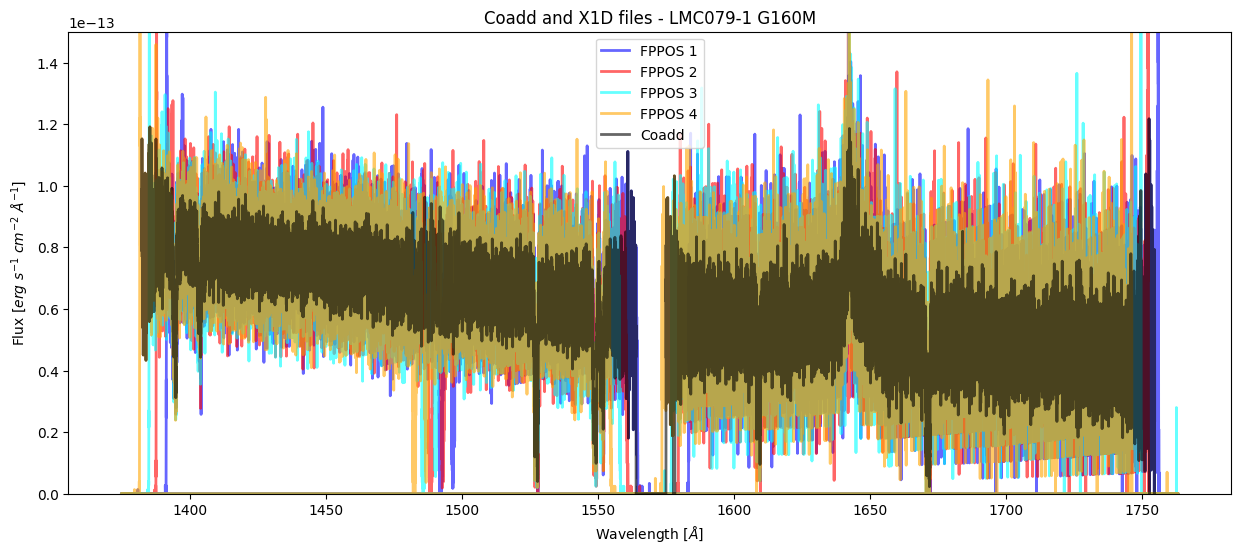

In [7]:
# Coadd filename
coadd_cos = "hst_15824_cos_lmc079-1_g160m_le27_cspec.fits"

# List of X1D files
x1ds = cos_unshifted.glob("*x1d*")

plt.figure(figsize=(15, 6))

colors = ["blue", "red", "cyan", "orange"]

# Plotting each X1D file
for i, file in enumerate(sorted(x1ds)):
    with fits.open(file) as hdul:

        wl = hdul[1].data["WAVELENGTH"].ravel()
        flux = hdul[1].data["FLUX"].ravel()

        plt.plot(wl, flux,
                 lw=2,
                 label=f'FPPOS {hdul[0].header["FPPOS"]}',
                 color=colors[i],
                 alpha=0.6)

# Plotting the coadd
with fits.open(cos_unshifted_coadd / coadd_cos) as hdul:

    wl_coadd = hdul[1].data["WAVELENGTH"].ravel()
    flux_coadd = hdul[1].data["FLUX"].ravel()

    plt.plot(wl_coadd, flux_coadd,
             lw=2,
             label="Coadd",
             color="black",
             alpha=0.6)

# Formatting and titles
plt.title("Coadd and X1D files - LMC079-1 G160M")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

plt.ylim(0, 1.5e-13)

plt.legend()

plt.show()

<a id = id_shift></a>
### 1.3 Identifying a Wavelength Shift in COS Data

It is up to the user to determine if their data needs to be shifted, and there are multiple different ways to determine if you need to calculate and apply shifts. It can sometimes be visually apparent that there is a wavelength offset when looking at spectral features as you'll see misalignment, but a more absolute method of determining if your data needs to be shifted is if you compare the coadd's radial velocity to the literature value. In our COS example, we will compare the coadd's radial velocity to the [ULLYSES](https://ullyses.stsci.edu/) High-Level Science Product's (HLSP) radial velocity. We will do a rough, quick calculation to demonstrate that there's an actual shift between the datasets; there are more accurate methods of determining the radial velocity but it is outside the scope of this notebook. The ULLYSES team has created [tutorial notebooks](https://github.com/spacetelescope/ullyses/blob/main/notebooks/ullyses-getrawdata.ipynb) that detail how to download this data via `astroquery`. We will download the HLSP for our target, specifically the file `hlsp_ullyses_hst_cos_lmc079-1_g160m_dr7_cspec.fits`, which is the HLSP for the `G160M` grating.

In [8]:
ullyses_query = Observations.query_criteria(
    target_name="LMC079-1",
    provenance_name="ULLYSES",
)

ullyses_prodlist = Observations.get_product_list(
    ullyses_query
)

ullyses_prodlist = Observations.filter_products(
    ullyses_prodlist,
    productFilename="hlsp_ullyses_hst_cos_lmc079-1_g160m_dr7_cspec.fits"
)

Observations.download_products(
    ullyses_prodlist,
    download_dir=str(cos_ex)
)

download_dir = cos_ex / "mastDownload"
hlsp_dir = download_dir / "HLSP/hlsp_ullyses_hst_cos_lmc079-1_uv"
target_filename = "hlsp_ullyses_hst_cos_lmc079-1_g160m_dr7_cspec.fits"

source_path = hlsp_dir / target_filename
hlsp_path = cos_ex / target_filename

shutil.move(str(source_path), str(hlsp_path))

shutil.rmtree(cos_ex / "mastDownload")

 [Done]


Now we can plot our coadd with the ULLYSES HLSP. We will zoom in on two different spectral features: `SiII` at `1526 Å` and `FeII` at `1608 Å`.

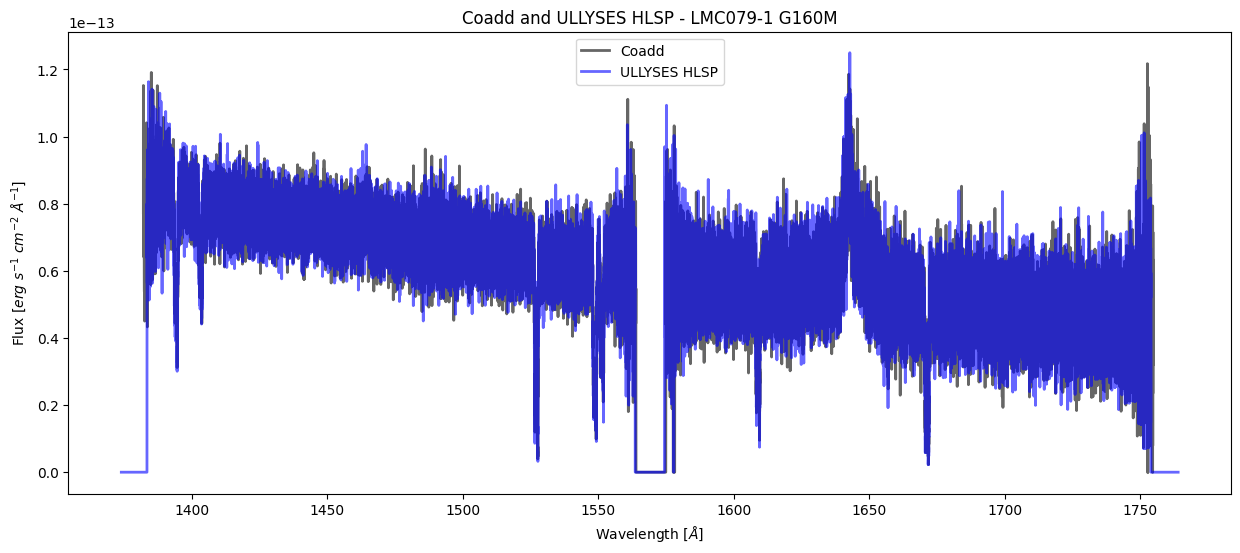

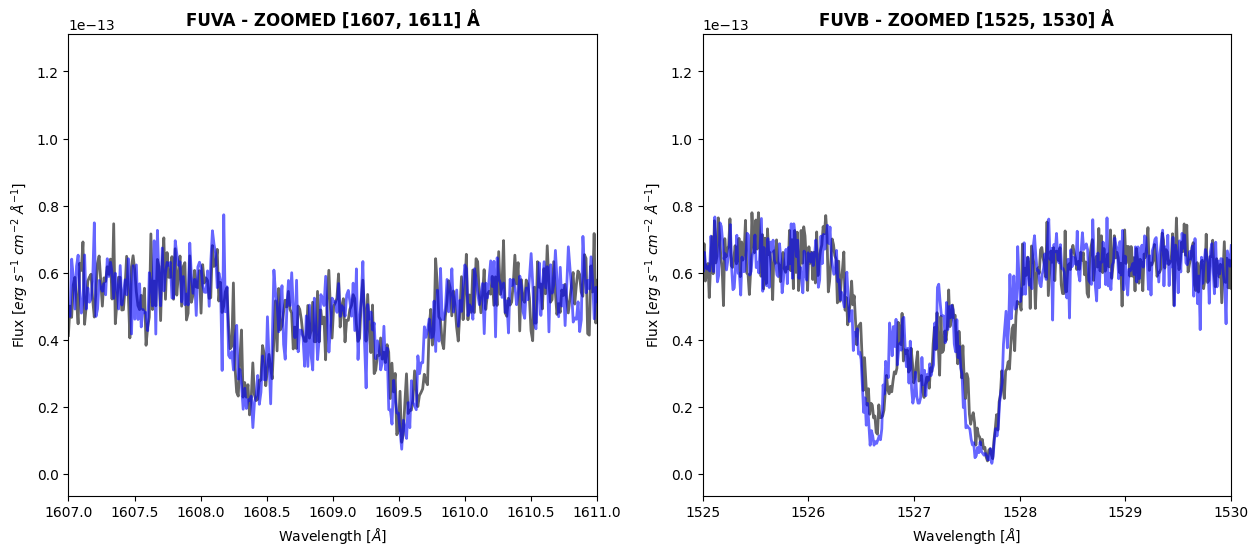

In [9]:
plt.figure(figsize=(15, 6))

wavelength_range = ([1607, 1611], [1525, 1530])

# Plotting the coadd
plt.plot(wl_coadd, flux_coadd,
         lw=2,
         label="Coadd",
         color="black",
         alpha=0.6)

# Plotting the ULLYSES HLSP
with fits.open(hlsp_path) as hdul:

    wl_hlsp = hdul[1].data["WAVELENGTH"].ravel()
    flux_hlsp = hdul[1].data["FLUX"].ravel()

plt.plot(wl_hlsp, flux_hlsp,
         lw=2,
         label="ULLYSES HLSP",
         color="blue",
         alpha=0.6)

plt.title("Coadd and ULLYSES HLSP - LMC079-1 G160M")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

plt.legend()

plt.show()

# Zooming in on two spectral features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for subplot in ax.ravel():

    # Plotting the coadd
    subplot.plot(wl_coadd, flux_coadd,
                 lw=2,
                 color="black",
                 alpha=0.6)

    # Plotting the HLSP
    subplot.plot(wl_hlsp, flux_hlsp,
                 lw=2,
                 color="blue",
                 alpha=0.6)

    subplot.set_xlabel(r'Wavelength [$\AA$]')
    subplot.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

ax[0].set_xlim(wavelength_range[0])
ax[0].set_title(f"FUVA - ZOOMED {wavelength_range[0]} Å",
                fontweight="bold")

ax[1].set_xlim(wavelength_range[1])
ax[1].set_title(f"FUVB - ZOOMED {wavelength_range[1]} Å",
                fontweight="bold")

plt.show()

We can see visually that there is a slight wavelength shift between the two data products. We will do a very rough estimate of the radial velocity using the `SiII` line at `1526.71 Å`.

We will first fit a Gaussian to our spectral feature to determine the model fit parameters of the absorption feature. Let's define the function below:

In [10]:
def fit_gaussian(wavelength, amplitude, mean, stddev):
    '''
    Fit a Gaussian to the data.
    Gaussian is defined as:
    f(x) = c + amplitude * np.exp(-(((wavelength - mean) / stddev)**2)/2)
    ----------
    Input:
    arr wavelength : Data of the independent variable (wl in our context)
    float amplitude : Amplitude of Gaussian. Represents the peak of the data
    float mean : Mean wl of Gaussian. Represents central wavelength of feature
    float stddev : Standard deviation of Gaussian. Represents function's width
    ----------
    Output:
    The value of flux at each wavelength using the fit.
    '''
    # An estimate of the continuum flux value
    c = 6.5e-14
    return c + amplitude * np.exp(-(((wavelength - mean) / stddev)**2)/2)

We will use `scipy.optimize` to help fit our model to the absorption feature by optimizing the parameters of the `fit_gaussian` function. We'll calculate the radial velocity of the HLSP first. This will allow us to determine the exact wavelength corresponding to the peak of the fitted Gaussian, which we'll use to calculate the radial velocity of the HLSP.

The SiII peak is fitted to be 1526.619 Å


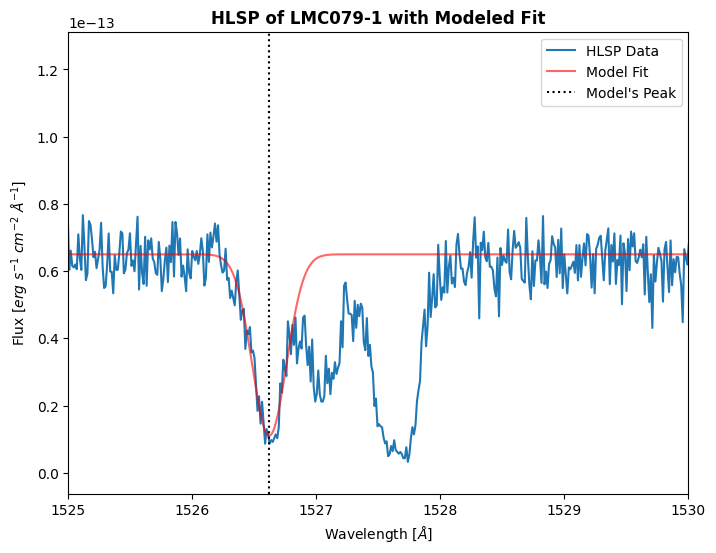

In [11]:
# Getting the indicies within the wavelength range
indicies = np.where((wl_hlsp >= 1525.1) & (wl_hlsp <= 1526.8))

trimmed_flux = flux_hlsp[indicies]
trimmed_wl = wl_hlsp[indicies]

# We need to make an initial guess for the parameter values
# The array is in form [PEAK OF GAUSSIAN, CENTRAL WAVELENGTH, WIDTH OF LINE]
p0 = [.8e-14, 1526.7, 0.0053]

popt_hlsp, _ = optimize.curve_fit(fit_gaussian,
                                  trimmed_wl,
                                  trimmed_flux,
                                  p0)

print(f"The SiII peak is fitted to be {np.round(popt_hlsp[1], 3)} Å")

# Plotting the absorption feature of the HLSP with our fit
plt.figure(figsize=(8, 6))

# Plotting the actual data
plt.plot(
    wl_hlsp,
    flux_hlsp,
    label="HLSP Data"
)

# Plotting our fit
plt.plot(
    wl_hlsp,
    fit_gaussian(wl_hlsp, *popt_hlsp),
    label="Model Fit",
    color="red",
    alpha=0.6
)

# Adding vertical lines to show fitted "peak"
plt.axvline(popt_hlsp[1],
            label='Model\'s Peak',
            color="black",
            linestyle="dotted")

plt.xlim(wavelength_range[1])
plt.legend()

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.title("HLSP of LMC079-1 with Modeled Fit",
          fontweight="bold")

plt.show()

Now that we've determined the observed wavelength of the `SiII` line, we can calculate the radial velocity. The rest wavelength of this line is `1526.71 Å`. We will use the equation below to calculate the radial velocity:

$ v_r = c \left( \frac{\lambda - \lambda_0}{\lambda_0} \right) $

Where:
- $ v_r $ is the radial velocity,
- $ c $ is the speed of light ($ \approx 2.99 * 10^5 $ km/s),
- $ \lambda $ is the observed wavelength of the spectral line,
- $ \lambda_0 $ is the rest wavelength of the spectral line.

Let's calculate it for the HLSP below:

In [12]:
# Speed of light (in km/s)
c = 2.99e5

# Getting the observed wavelength of our HLSP
observed_wavelength = popt_hlsp[1]

# Rest wavelength of SiII
rest_wavelength = 1526.71

v_r = c * ((observed_wavelength - rest_wavelength) / rest_wavelength)
v_r = np.round(v_r, 2)

print(f"The radial velocity of LMC079-1 using the HLSP is roughly {v_r} km/s")

The radial velocity of LMC079-1 using the HLSP is roughly -17.78 km/s


Now let's calculate the radial velocity of our coadd using the same process.

The SiII peak is fitted to be 1526.663 Å


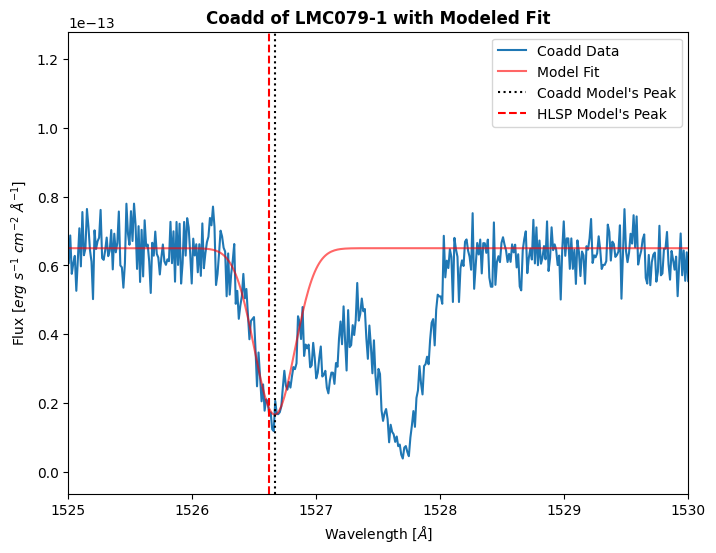

The radial velocity of LMC079-1 using the coadd is roughly -9.17 km/s


In [13]:
# Getting the indicies within the wavelength range
indicies = np.where((wl_coadd >= 1525.) & (wl_coadd <= 1526.8))

trimmed_flux = flux_coadd[indicies]
trimmed_wl = wl_coadd[indicies]

# We need to make an initial guess for the parameter values
# The array is in form [PEAK OF GAUSSIAN, CENTRAL WAVELENGTH, WIDTH OF LINE]
p0 = [.75e-14, 1526.7, 0.0055]

popt, _ = optimize.curve_fit(fit_gaussian,
                             trimmed_wl,
                             trimmed_flux,
                             p0)

print(f"The SiII peak is fitted to be {np.round(popt[1], 3)} Å")

# Plotting the absorption feature of the HLSP with our fit
plt.figure(figsize=(8, 6))

# Plotting the actual data
plt.plot(
    wl_coadd,
    flux_coadd,
    label="Coadd Data"
)

# Plotting our fit
plt.plot(
    wl_coadd,
    fit_gaussian(wl_coadd, *popt),
    label="Model Fit",
    color="red",
    alpha=0.6
)

# Adding vertical lines to show fitted "peak"
plt.axvline(popt[1],
            label='Coadd Model\'s Peak',
            color="black",
            linestyle="dotted")

# Adding vertical line to show observed wl of HLSP
plt.axvline(popt_hlsp[1],
            label='HLSP Model\'s Peak',
            color="red",
            linestyle="dashed")

plt.xlim(wavelength_range[1])
plt.legend()

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

plt.title("Coadd of LMC079-1 with Modeled Fit",
          fontweight="bold")

plt.show()

# Getting the observed wavelength of our HLSP
observed_wavelength = popt[1]

v_r = c * ((observed_wavelength - rest_wavelength) / rest_wavelength)
v_r = np.round(v_r, 2)

print(f"The radial velocity of LMC079-1 using the coadd is roughly {v_r} km/s")

We can see that there is a very significant difference between the target's calculated radial velocity using the HLSP (roughly `-17.78 km/s`) and the coadd (roughly `-3.5 km/s`). This is an indicator that there is a wavelength offset between the coadd's constituent `X1D` files. We will need to determine this wavelength offset between the `X1D` files, apply this shift when running `CalCOS`, and redo the coadd. 

<a id = cc_cos></a>
### 1.4 Performing Cross-Correlation on `X1D` COS Data to Calculate Lag

We will determine the shift of our spectrum by cross-correlating one of the `X1D` files to the other files, determining the lag with the greatest cross-correlation coefficient, and then inputting this lag into `CalCOS` to re-generate the `X1D` files. We will need to calculate the shift, in pixels, for both the `FUVA` and `FUVB` segments of each `X1D`. Users will want to cross-correlate along a wavelength range that captures absorption features unique to the target and is free of instrumental effects. Additionally, cross-correlating across a unique feature of the spectrum rather than the entire spectrum greatly improves the cross-correlation accuracy.

We will cross-correlate along the ranges `1525 - 1530 Å` for Segment `FUVB` and `1607 - 1611 Å` for Segment `FUVA`, which capture `SiII` and `FeII` absorption features of this spectrum, respectively. Let's take a closer look at these spectra:

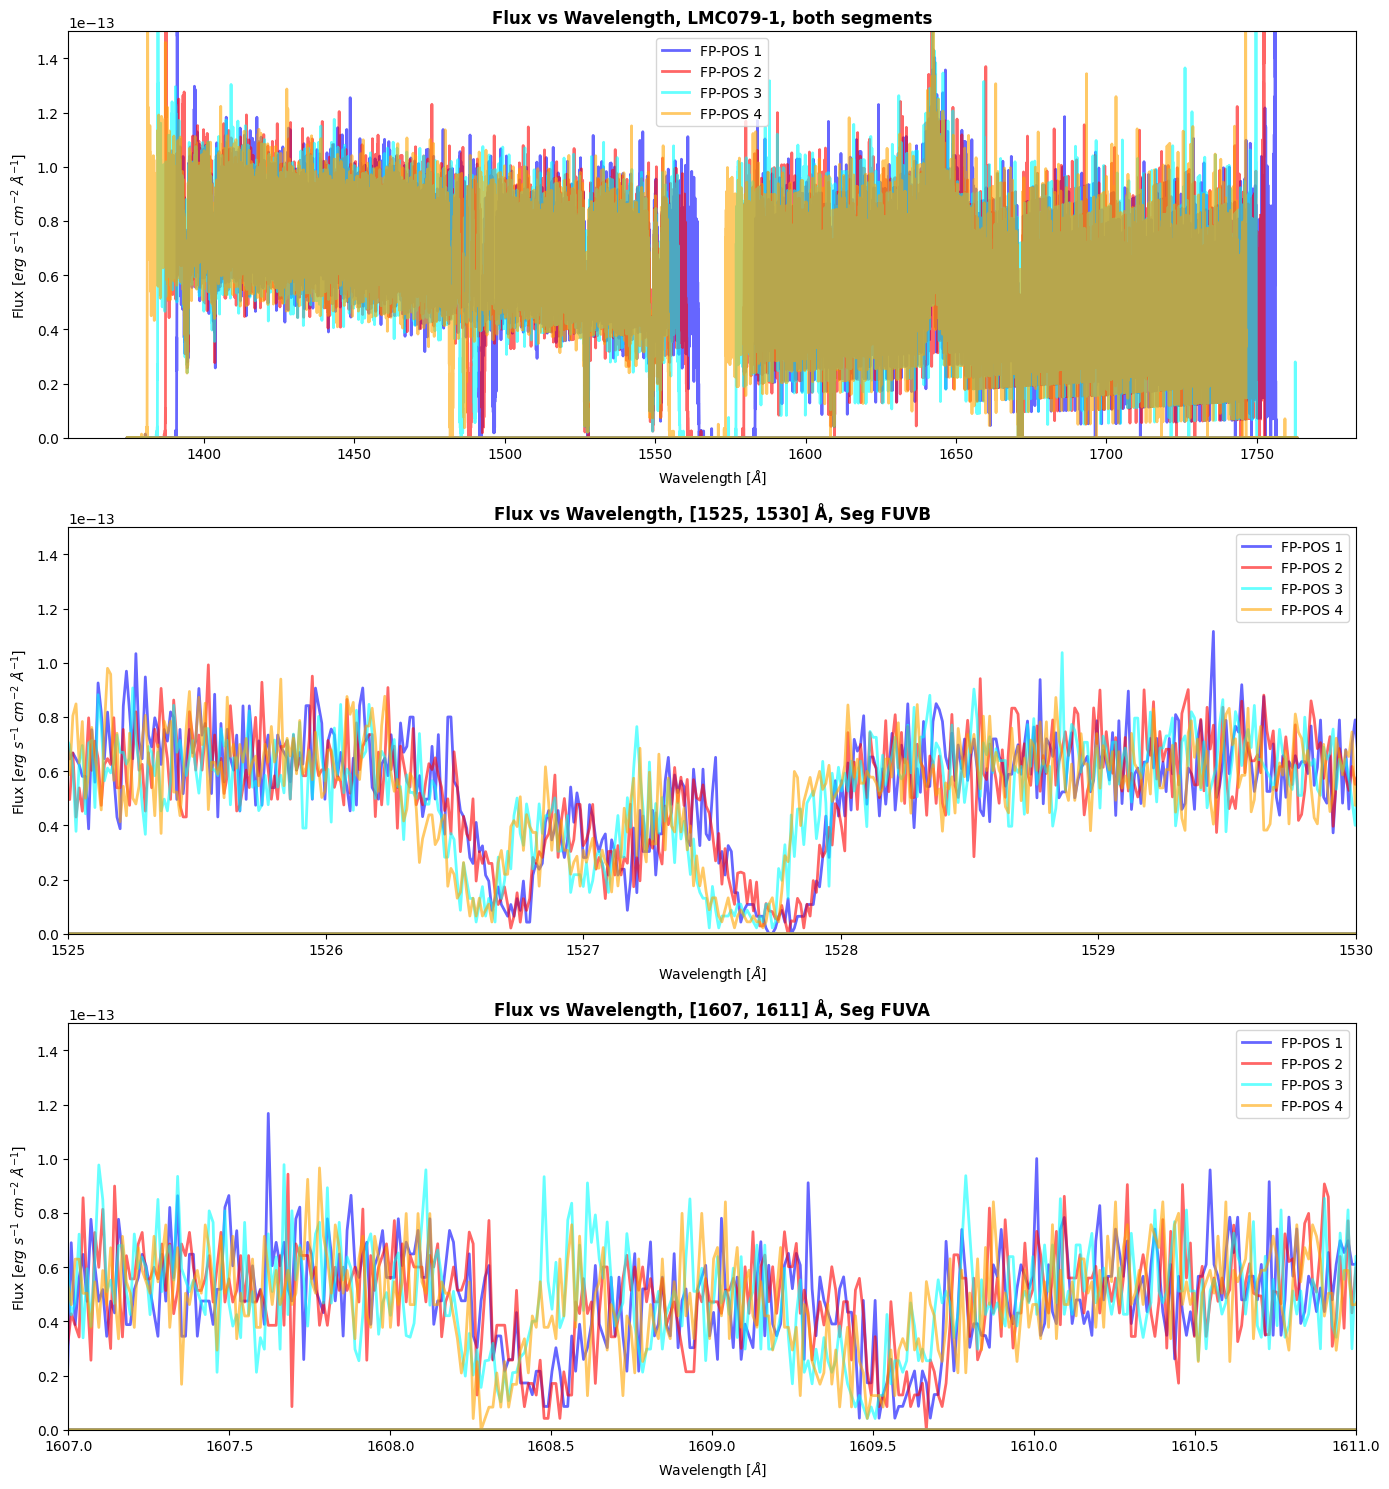

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(14, 15))

x1ds = cos_unshifted.glob("*x1d*")

for i, file in enumerate(sorted(x1ds)):

    # Getting the flux and wavelength for our dataset
    data = fits.open(file)[1].data
    wavelength = data["WAVELENGTH"].ravel()
    flux = data["FLUX"].ravel()

    fppos = fits.open(file)[0].header["FPPOS"]

    # ax[0] is plot with total spectrum, ax[1] is FUVB, ax[2] is FUVA
    for subplot in ax:
        # Plotting the spectrum
        subplot.plot(wavelength, flux,
                     lw=2,
                     alpha=0.6,
                     color=colors[i],
                     label=f"FP-POS {fppos}")

        subplot.set_xlabel(r'Wavelength [$\AA$]')
        subplot.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

        subplot.set_ylim(0, 1.5e-13)

        subplot.legend()

# Adding formatting to the subplots
ax[0].set_title("Flux vs Wavelength, LMC079-1, both segments",
                fontweight="bold")
ax[1].set_title(f'Flux vs Wavelength, {wavelength_range[1]} Å, Seg FUVB',
                fontweight="bold")
ax[2].set_title(f'Flux vs Wavelength, {wavelength_range[0]} Å, Seg FUVA',
                fontweight="bold")

ax[1].set_xlim(wavelength_range[1])
ax[2].set_xlim(wavelength_range[0])

ax[0].legend()

fig.tight_layout()

plt.show()

We can see an apparent shift between the `X1D` files, especially between the `FPPOS 1+2` and `FPPOS 3+4` exposures.

We will now determine which `X1D` file will be the reference file. Users have different methods for determining the reference file best suited for your dataset. For this example, we will choose the reference file to be the `X1D` with a model peak closest to the HLSP's peak of the `SiII` absorption feature.

We'll define a function to help us fit the peaks:

In [15]:
def fit_model(i, p0, ax, wavelength_range, file):
    '''
    Fit the Gaussian to the feature, return the "peak" wavelength
    ----------
    arr i : The wavelength range to trim flux/wl to
    arr p0 : The initial guess for the Gaussian fit
    plt.subplot ax : A specific subplot, used for plotting each X1D
    arr wavelength_range : Wavelength range for the plot
    str file : Path to the X1D file
    '''
    with fits.open(file) as hdul:
        wl = hdul[1].data["WAVELENGTH"].ravel()
        flux = hdul[1].data["FLUX"].ravel()

    # Getting the indicies within the wavelength range
    indicies = np.where((wl >= i[0]) & (wl <= i[1]))

    trimmed_flux = flux[indicies]
    trimmed_wl = wl[indicies]

    popt, _ = optimize.curve_fit(fit_gaussian,
                                 trimmed_wl,
                                 trimmed_flux,
                                 p0)

    # Plotting the X1D's data
    ax.plot(
        wl,
        flux
    )

    # Plotting the fit
    ax.plot(
        wl,
        fit_gaussian(wl, *popt),
        label="Modeled Fit",
        color="purple"
    )

    # Adding vertical line to show peak wl of HLSP
    ax.axvline(popt_hlsp[1],
               label='HLSP Model\'s Peak',
               color="red",
               linestyle="dashed")

    # Adding vertical line to show peak wl of X1D
    ax.axvline(popt[1],
               label='X1D Model\'s Peak',
               color="black",
               linestyle="dotted")

    ax.set_xlim(wavelength_range)
    ax.set_ylim(0, 1.5e-13)

    ax.legend()

    fppos = fits.getval(file, "FPPOS")
    ax.set_title(f'Flux vs Wavelength with Fit, FPPOS {fppos}',
                 fontweight="bold")

    ax.set_xlabel(r'Wavelength [$\AA$]')
    ax.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    peak_diff = np.round(popt[1] - popt_hlsp[1], 3)

    ax.text(wavelength_range[1] - 1.35,
            1.2e-13,
            f'Difference in peak wavelength = {peak_diff} Å',
            ha='center', va='center')

    return peak_diff

Now we will determine the file to be used as a reference, which will be the file that has the smallest difference in peak wavelength for the `SiII` feature compared to the HLSP peak.

/tmp/ipykernel_3136/1408116224.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = optimize.curve_fit(fit_gaussian,


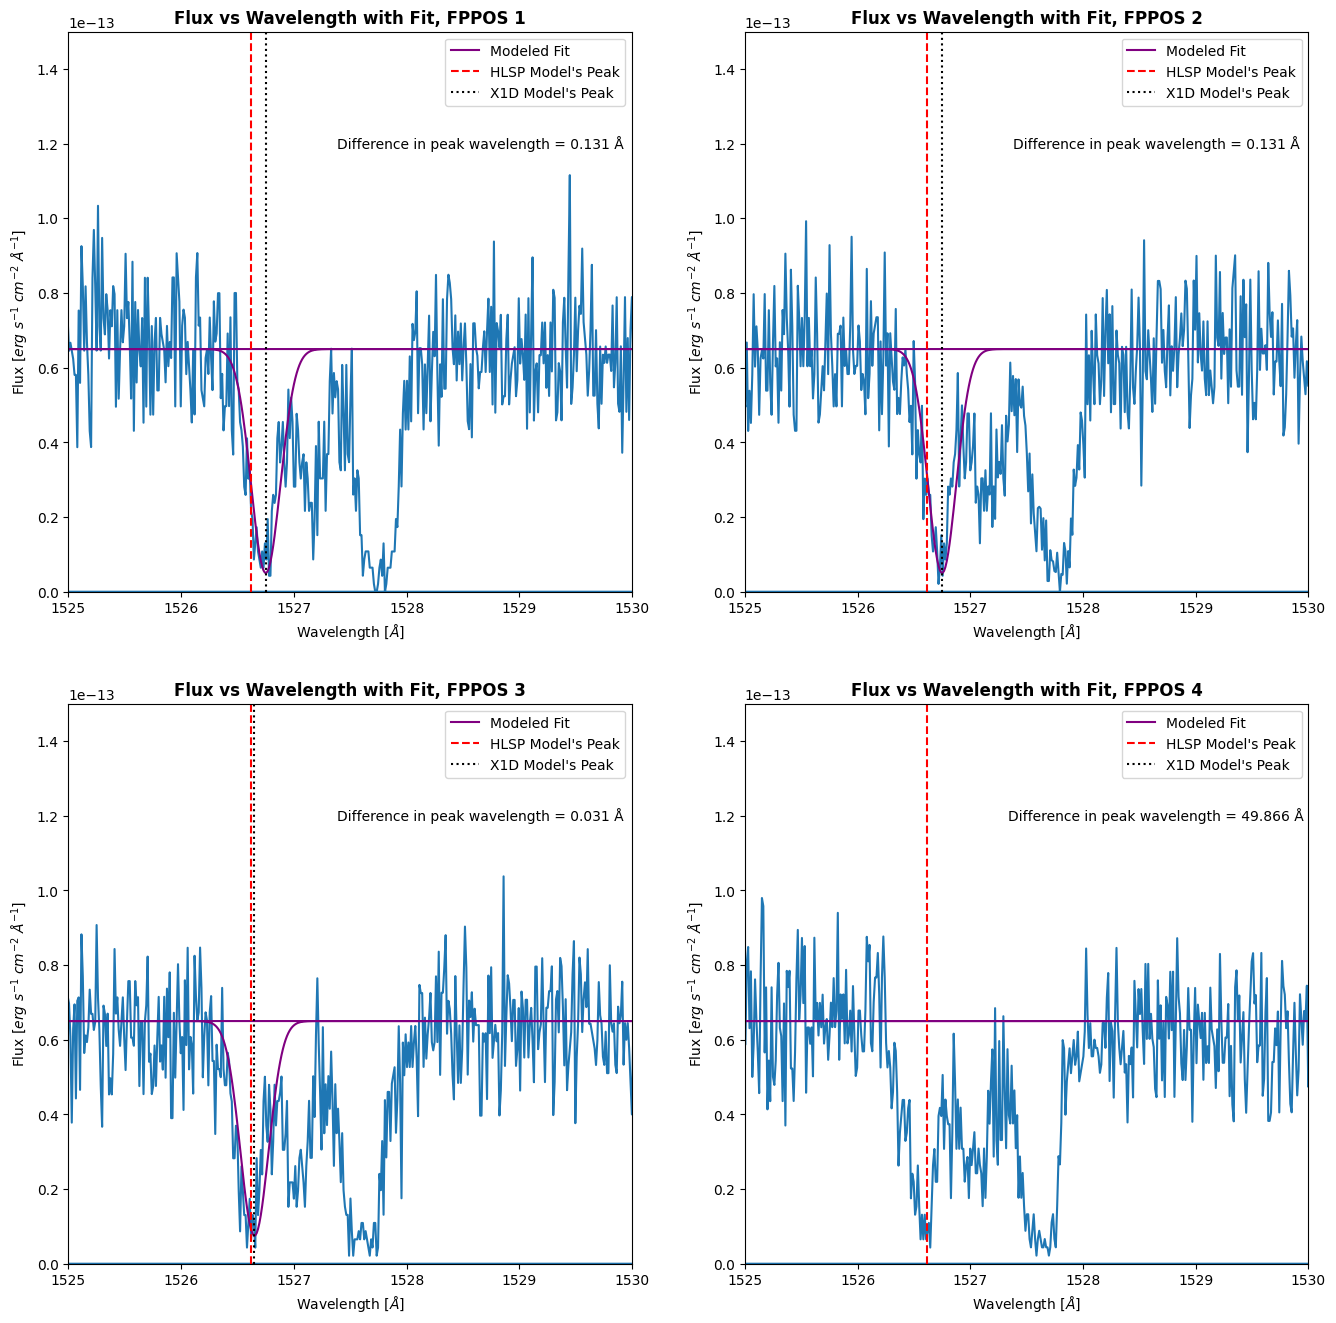

The file to be used as reference was taken at FPPOS 3


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

x1ds = list(cos_unshifted.glob("*x1d*"))

# A placeholder reference file
ref_file = x1ds[0]

# A placeholder value for the smallest peak
smallest_peak = 10000

for file, ax in zip(sorted(x1ds), axes.ravel()):
    fppos = fits.getval(file, "FPPOS")
    i = [1525., 1525.8]

    if fppos == 1:
        p0 = [-6e-14, 1526.75, 0.13]

    elif fppos == 2:
        p0 = [-6e-14, 1526.75, 0.125]

    elif fppos == 3:
        p0 = [-5.75e-14, 1526.65, 0.125]

    elif fppos == 4:
        p0 = [-5.8e-14, 1526.62, 0.13]

    curr_peak = fit_model(i, p0, ax, wavelength_range[1], file)

    # Is the current iteration's file closer to the HLSP?
    if np.abs(curr_peak) < smallest_peak:
        smallest_peak = np.abs(curr_peak)
        ref_file = file

plt.show()

fppos = fits.getval(ref_file, "FPPOS")
print(f'The file to be used as reference was taken at FPPOS {fppos}')

As we can see, the file that is closest to the HLSP is the observation taken at `FPPOS 4`.

We will now define a function to determine the lag and cross-correlation coefficient between our reference and shifted spectra. We will use the `correlation_lags` function from `scipy.signal` to compute the cross-correlation coefficient for each lag. The lag is the displacement (in pixels) between the reference and current spectra. The cross-correlation coefficient is in the range `[-1, 1]`, a value of `1` being perfectly correlated, `0` being no correlation, and `-1` being inversely correlated. The shift that we will input to `CalCOS` is going to be the lag at the maximum cross-correlation coefficient value. We will define the function to calculate the lag and cross-correlation coefficient in the cell below (this function is from the [STIS Cross Correlation Notebook](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/STIS/cross-correlation/cross-correlation.ipynb)).

In [17]:
# From the STIS cross correlation notebook
def cross_correlate(ref_flux, shifted_flux):
    assert len(shifted_flux) == len(ref_flux), "Arrays must be same size"

    # Normalize inputs:
    shifted_flux = shifted_flux - shifted_flux.mean()
    shifted_flux /= shifted_flux.std()
    ref_flux = ref_flux - ref_flux.mean()
    ref_flux /= ref_flux.std()

    # centered at the median of len(a)
    lag = correlation_lags(len(shifted_flux), len(ref_flux), mode="same")
    # find the cross-correlation coefficient
    cc = correlate(shifted_flux, ref_flux, mode="same") / float(len(ref_flux))

    return lag, cc

Now we will define a function to calculate the shift between our reference file (`FPPOS 4`) and the `FPPOS 1+2+3` exposures. We will plot the correlation coefficient vs lag as well. We will have to get shift values for each segment; for `FUVA` we will correlate to the wavelength range `[1607, 1611]`, and for `FUVB` we will correlate to the wavelength range `[1525, 1530]`. Since our `cross_correlate` function returns only discrete value shifts, we will need to fit a curve to the correlation lag plot; the shift we will apply with `CalCOS` is at the maxima of this curve. 

**Note: You will need to experiment with different fits for your dataset.**

In [18]:
def find_shift_normalized(ref_file, file, wl_range, segment, width, plot):
    '''
    Determine shift amount in pixels between the reference file and the file.
    Can also plot wavelength range and the correlation coeff. vs lag as well.
    ----------
    Input:
    Pathlib path ref_file : Path to reference file's spectrum to shift to.
    Pathlib path file : Path to file of spectrum to apply shifts to
    arr wl_range : Wavelength range to correlate to. Form: [START_WL, END_WL]
    str segment : The segment that is being correlated. Either 'FUVA' or 'FUVB'
    int width : Width of fit, needs to be greater than 2
    bool plot : Do you want to show plots?
    ----------
    Output:
    float shift : Calculated lag [px] between ref and current spectrum
    '''
    # Grabbing the reference spectrum's data
    with fits.open(ref_file) as hdul:
        seg_i = np.where(hdul[1].data["SEGMENT"] == segment)

        ref_wl = hdul[1].data["WAVELENGTH"][seg_i]
        ref_flux = hdul[1].data["FLUX"][seg_i]

    # Getting the flux data for the current FPPOS file
    with fits.open(file) as hdul:
        seg_i = np.where(hdul[1].data["SEGMENT"] == segment)
        flux = hdul[1].data["FLUX"][seg_i]

    range_i = np.where((ref_wl >= wl_range[0]) & (ref_wl <= wl_range[1]))

    # Trimming the flux and wavelength ranges to match the user inputted range
    flux = flux[range_i]
    ref_flux = ref_flux[range_i]

    wavelength = ref_wl[range_i]

    # Calculating lag and correlation coeff. using STIS notebook's function
    lag, cc = cross_correlate(ref_flux, flux)

    # Fitting a quadratic to the peak to find pixel shift
    fitter = fitting.LinearLSQFitter()

    # Getting the points near the peak
    low, hi = np.argmax(cc) - width//2, np.argmax(cc) + width//2 + 1
    fit = fitter(Polynomial1D(degree=2), x=lag[low:hi], y=cc[low:hi])

    x_c = np.arange(np.min(lag), np.max(lag), 0.01)

    # Determining the shift, in pixels
    shift1 = -fit.parameters[1] / (2. * fit.parameters[2])

    if segment == "FUVA":
        shift = shift1 + fits.getval(file, "SHIFT1A", ext=1)

    else:
        shift = shift1 + fits.getval(file, "SHIFT1B", ext=1)

    # If not plotting, then just return the shift
    if plot is False:
        return shift

    fppos = fits.getval(file, 'FPPOS')

    print(f"Shift for {segment} between ref and FPPOS {fppos} is {shift1} px")

    # Setting up the subplots
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    ax[0].plot(
        wavelength,
        ref_flux,
        lw=2,
        label="Reference File"
    )

    ax[0].plot(
        wavelength,
        flux,
        lw=2,
        label=f'FPPOS {fits.getval(file, "FPPOS")}'
    )

    ax[1].plot(
        lag,
        cc,
        lw=2,
        color="black"
    )

    ax[1].plot(
        x_c,
        fit(x_c),
        lw=2,
        color="red",
        label="Fitted quadratic",
        alpha=0.6
    )

    ax[1].axvline(
        shift1,
        linestyle="dashed",
        label="Maxima",
    )

    ax[1].legend()
    ax[1].set_ylim(-0.3, 0.8)
    ax[1].set_xlim(shift1-100, shift1+100)

    # Adjusting formatting + adding titles
    ax[0].set_xlabel("Wavelength")
    ax[0].set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    ax[0].set_title(f'Flux vs Wavelength, FPPOS {fppos} & Ref, {segment}',
                    weight="bold")

    ax[1].set_xlabel("Lags (px)")
    ax[1].set_ylabel("Correlation Coeff.")
    ax[1].set_title(f'CC vs Lags (px), FPPOS {fppos} & Ref, {segment}',
                    weight="bold")

    ax[0].legend()

    plt.tight_layout()
    plt.show()

    return

Let's calculate the shift of both segments for the `FPPOS 1` exposure:

Shift for FUVA between ref and FPPOS 1 is 12.703590140319356 px


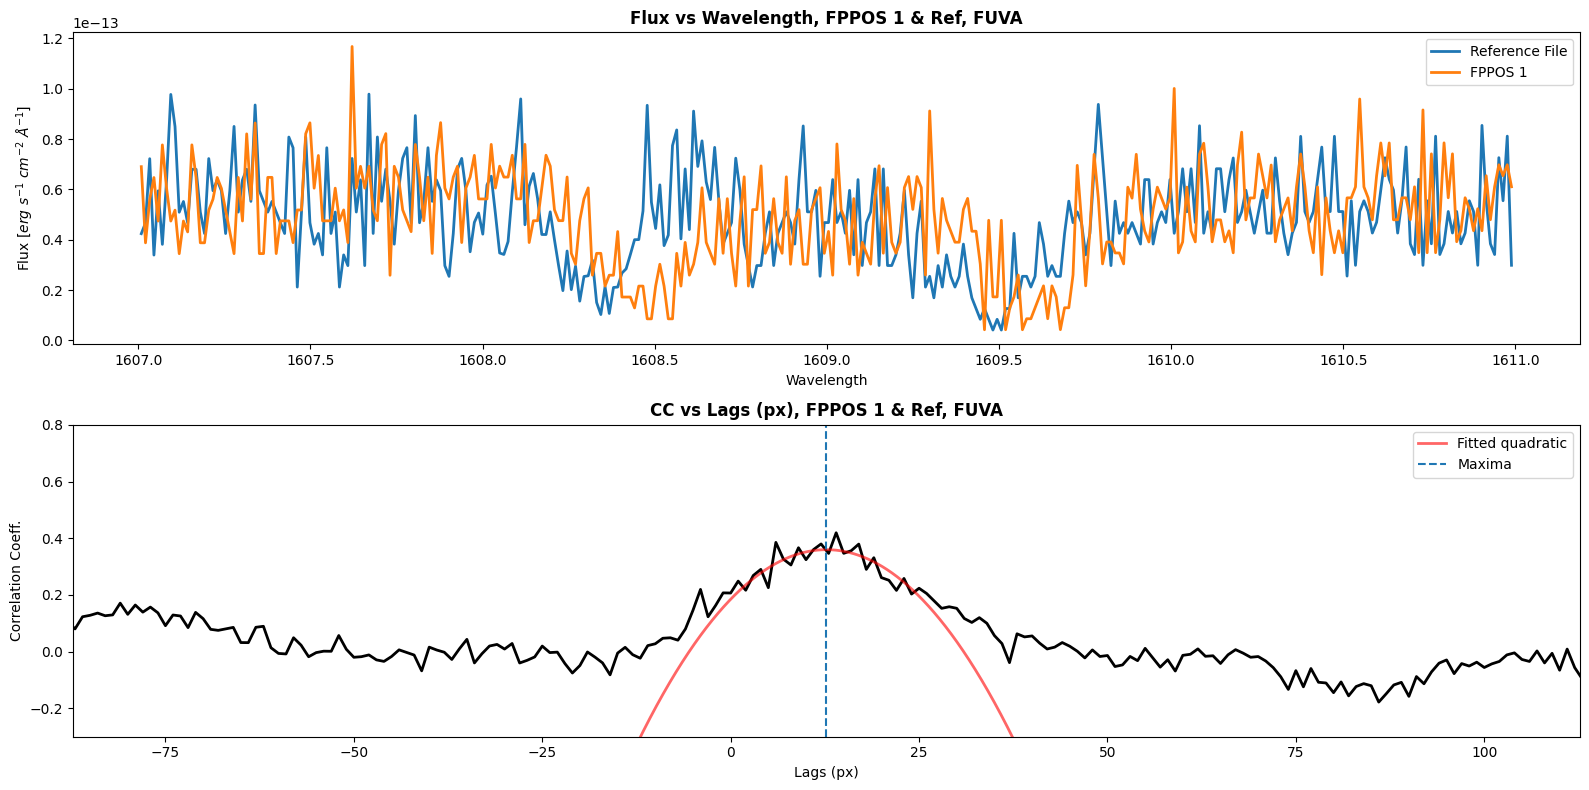

Shift for FUVB between ref and FPPOS 1 is 9.85607763984397 px


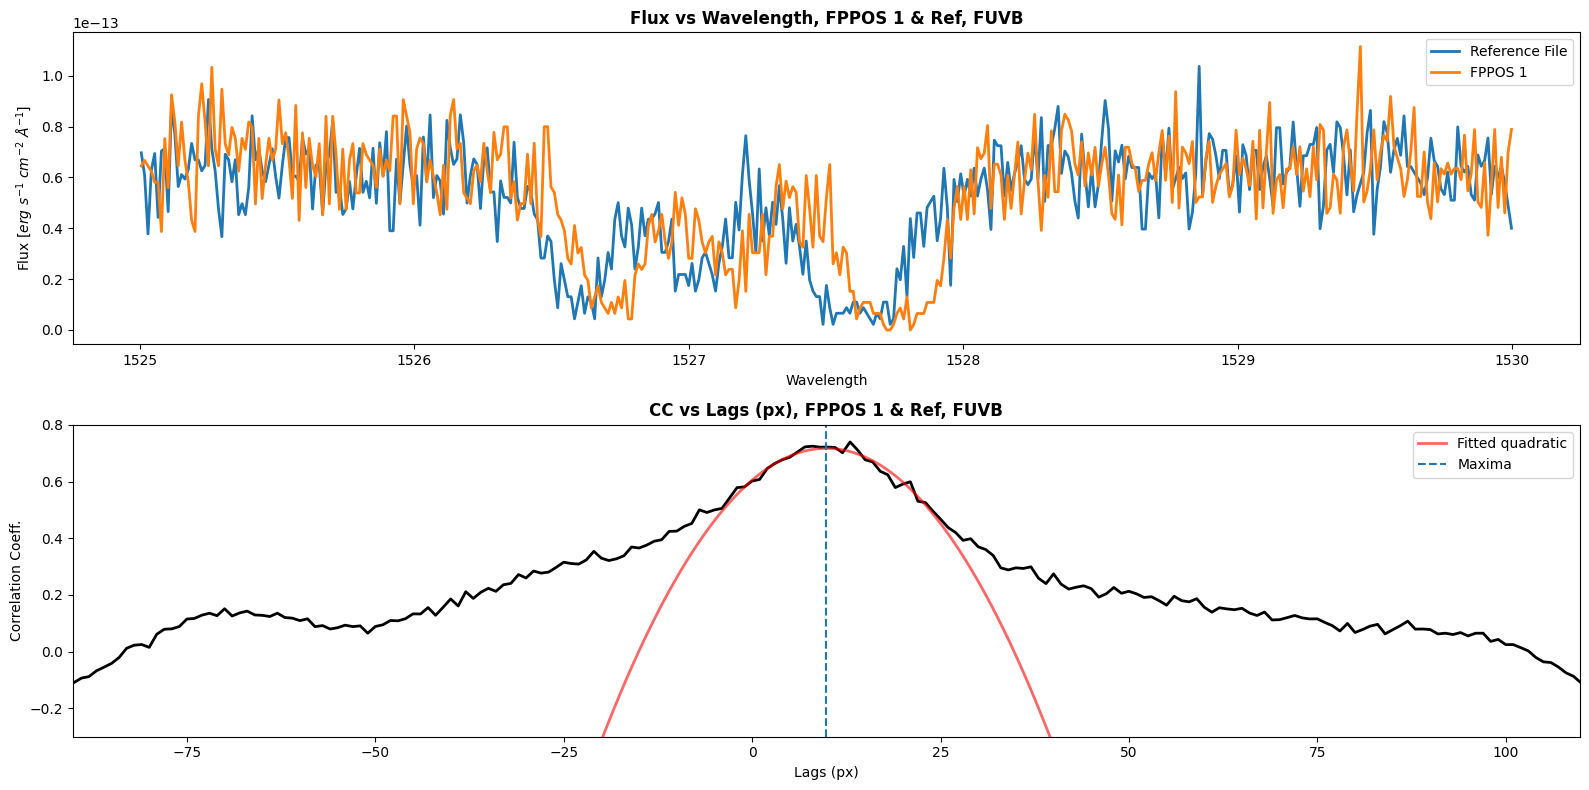

In [19]:
fppos1 = cos_unshifted / "le2701q0q_x1d.fits"

widths1 = [25, 25]

find_shift_normalized(ref_file,
                      fppos1,
                      wavelength_range[0],
                      "FUVA",
                      width=widths1[0],
                      plot=True)

find_shift_normalized(ref_file,
                      fppos1,
                      wavelength_range[1],
                      "FUVB",
                      width=widths1[1],
                      plot=True)

Now we can do the same for our `FPPOS 2` exposure:

Shift for FUVA between ref and FPPOS 2 is 11.247091769401665 px


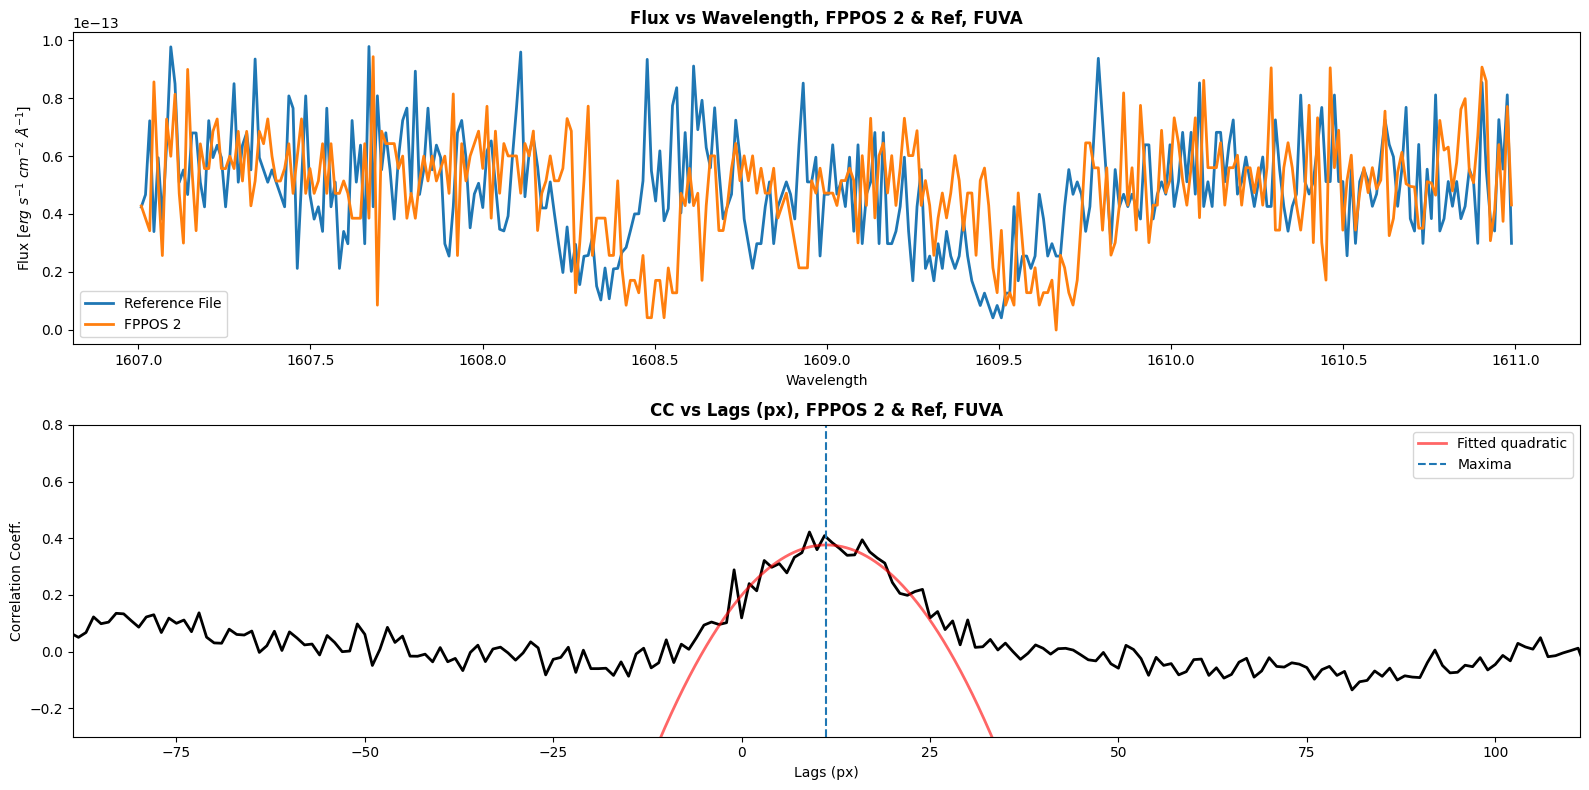

Shift for FUVB between ref and FPPOS 2 is 9.713870268304158 px


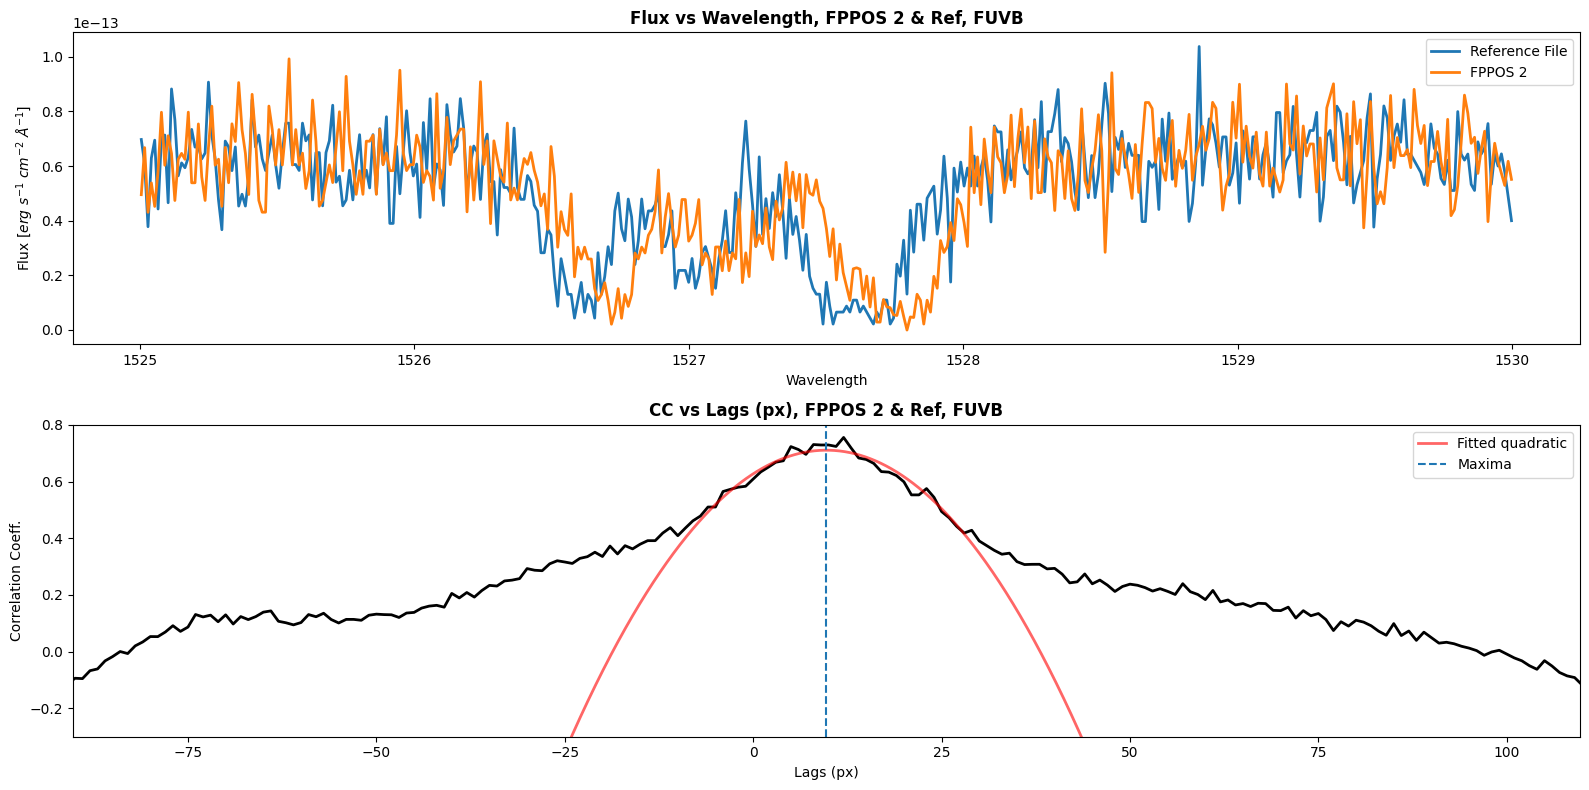

In [20]:
fppos2 = cos_unshifted / "le2701q2q_x1d.fits"

widths2 = [25, 35]

find_shift_normalized(ref_file,
                      fppos2,
                      wavelength_range[0],
                      "FUVA",
                      width=widths2[0],
                      plot=True)

find_shift_normalized(ref_file,
                      fppos2,
                      wavelength_range[1],
                      "FUVB",
                      width=widths2[1],
                      plot=True)

And finally, let's calculate the shift for our `FPPOS 3` exposure:

Shift for FUVA between ref and FPPOS 3 is 0.0 px


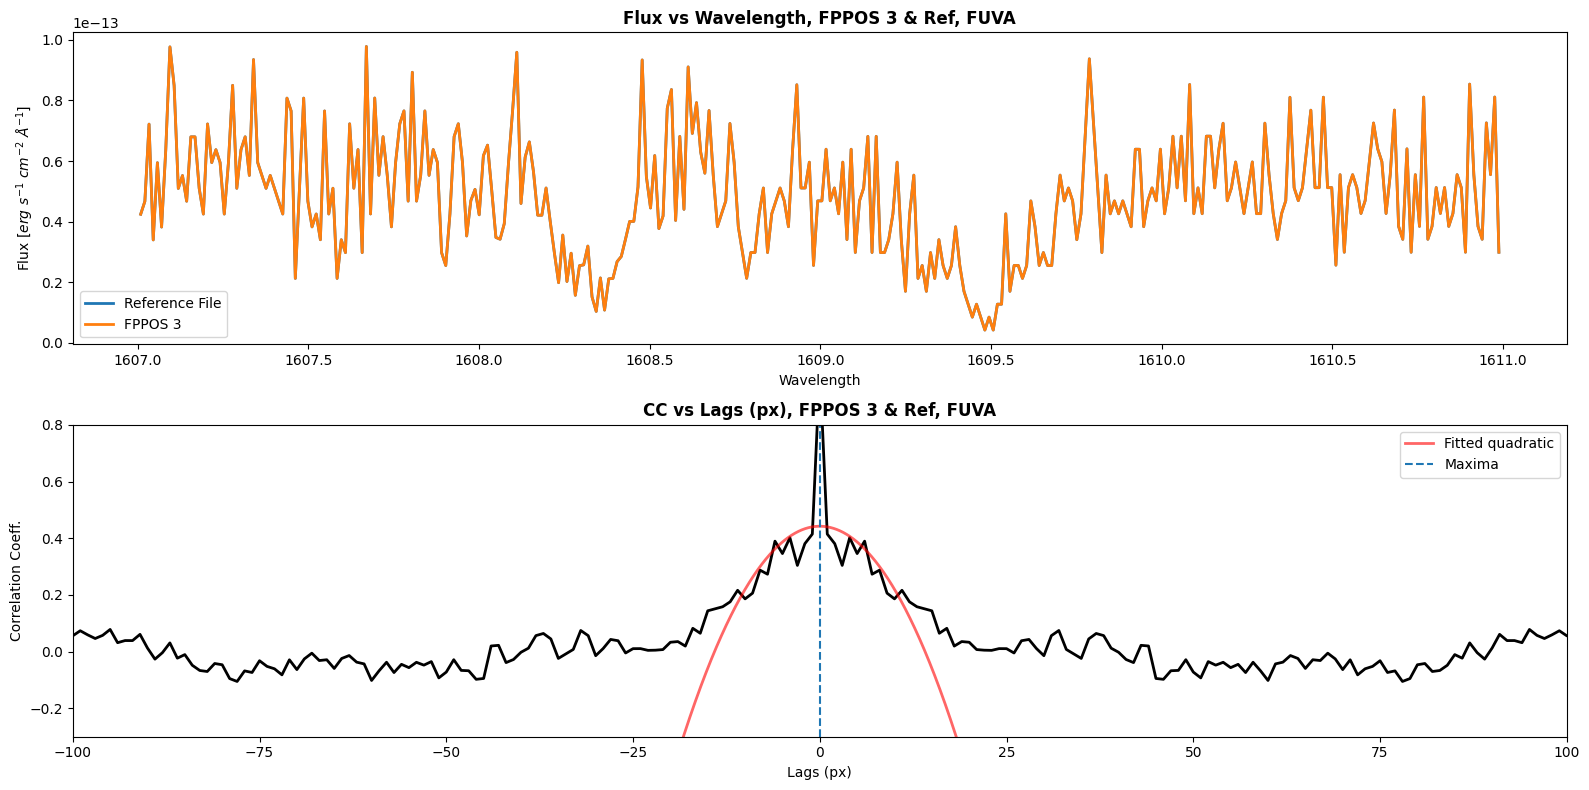

Shift for FUVB between ref and FPPOS 3 is 0.0 px


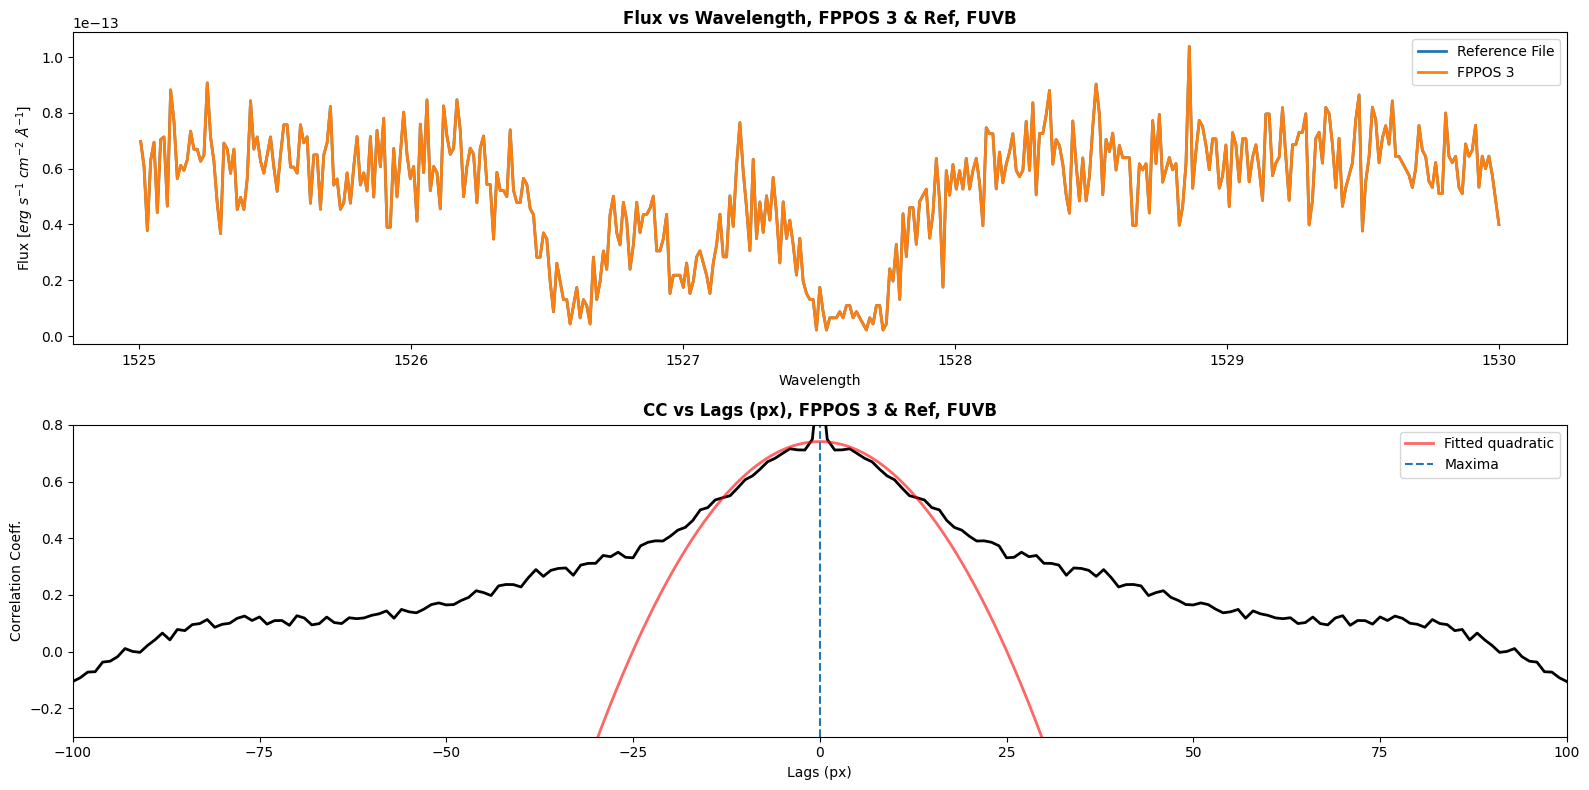

In [21]:
fppos3 = cos_unshifted / "le2701q4q_x1d.fits"

widths3 = [25, 30]

find_shift_normalized(ref_file,
                      fppos3,
                      wavelength_range[0],
                      "FUVA",
                      width=widths3[0],
                      plot=True)

find_shift_normalized(ref_file,
                      fppos3,
                      wavelength_range[1],
                      "FUVB",
                      width=widths3[1],
                      plot=True)

<a id = apply_shifts_cos></a>
### 1.5 Applying Shifts to COS data and Re-creating Coadd

Now that we've determined the shift in pixels, we will re-calibrate our data using `CalCOS`. There are two ways that we can apply our shifts: we can either modify the `corrtag` files, or we can put them in a `.txt` file and feed that into `CalCOS`. We will do the latter option in this tutorial. The shift value that we will write in the `.txt` file is the sum of the shift we calculated using the above function and the value of the `SHIFT1A` header keyword of the `X1D` file (`SHIFT1A` for `FUVA`, `SHIFT1B` for `FUVB`).

The `shifts.txt` file must have the following columns:

\- `ROOTNAME`

\- `FPOFFSET`

\- `FLASH/STRIPE/SEGMENT`

\- New `SHIFT1` value in pixels (dispersion direction shift)

\- New `SHIFT2` value in pixels (cross-dispersion direction shift)**

_**Note: including the `SHIFT2` value is optional_

If the `ROOTNAME` is not the association's rootname, then you can specify `FPOFFSET` as `any` in the file. This goes for `FLASH/STRIPE/SEGMENT` as well, but we will be specifying the segment in our example because we had to calculate the shifts for each segment. More information about running `CalCOS` when applying the shifts can be found in [Section 5.3.2 of the COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-3-working-with-extracted-spectra).

Running the cell below will create a `shifts.txt` file, which will be inputted into `CalCOS` to apply the new shifts to the datasets.

In [22]:
with open(cos_data / "shifts.txt", "w") as shift_file:
    widths = (widths1, widths2, widths3)
    for file, width in zip([fppos1, fppos2, fppos3], widths):

        rootname = fits.getval(file, "ROOTNAME")

        shift_fuva = find_shift_normalized(ref_file,
                                           file,
                                           wavelength_range[0],
                                           "FUVA",
                                           width=width[0],
                                           plot=False)

        shift_file.write(f'{rootname} any any FUVA {shift_fuva}\n')

        shift_fuvb = find_shift_normalized(ref_file,
                                           file,
                                           wavelength_range[1],
                                           "FUVB",
                                           width=width[1],
                                           plot=False)

        shift_file.write(f'{rootname} any any FUVB {shift_fuvb}\n')

Now we can run `CalCOS` on our data to perform the shift. Check out the COS team's [`CalCOS` notebook](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/CalCOS/CalCOS.ipynb) for a tutorial on how to run `CalCOS`.

In [23]:
%%capture cap --no-stderr
try:
    calcos.calcos(f"{cos_data}/le2701010_asn.fits",
                  outdir=str(cos_shifted),
                  shift_file=f"{cos_data}/shifts.txt")
    
except RuntimeError as e:
    print('An error occured', e)

Let's compare the pre-shifted and shifted wavelength ranges of our observations for both segments:

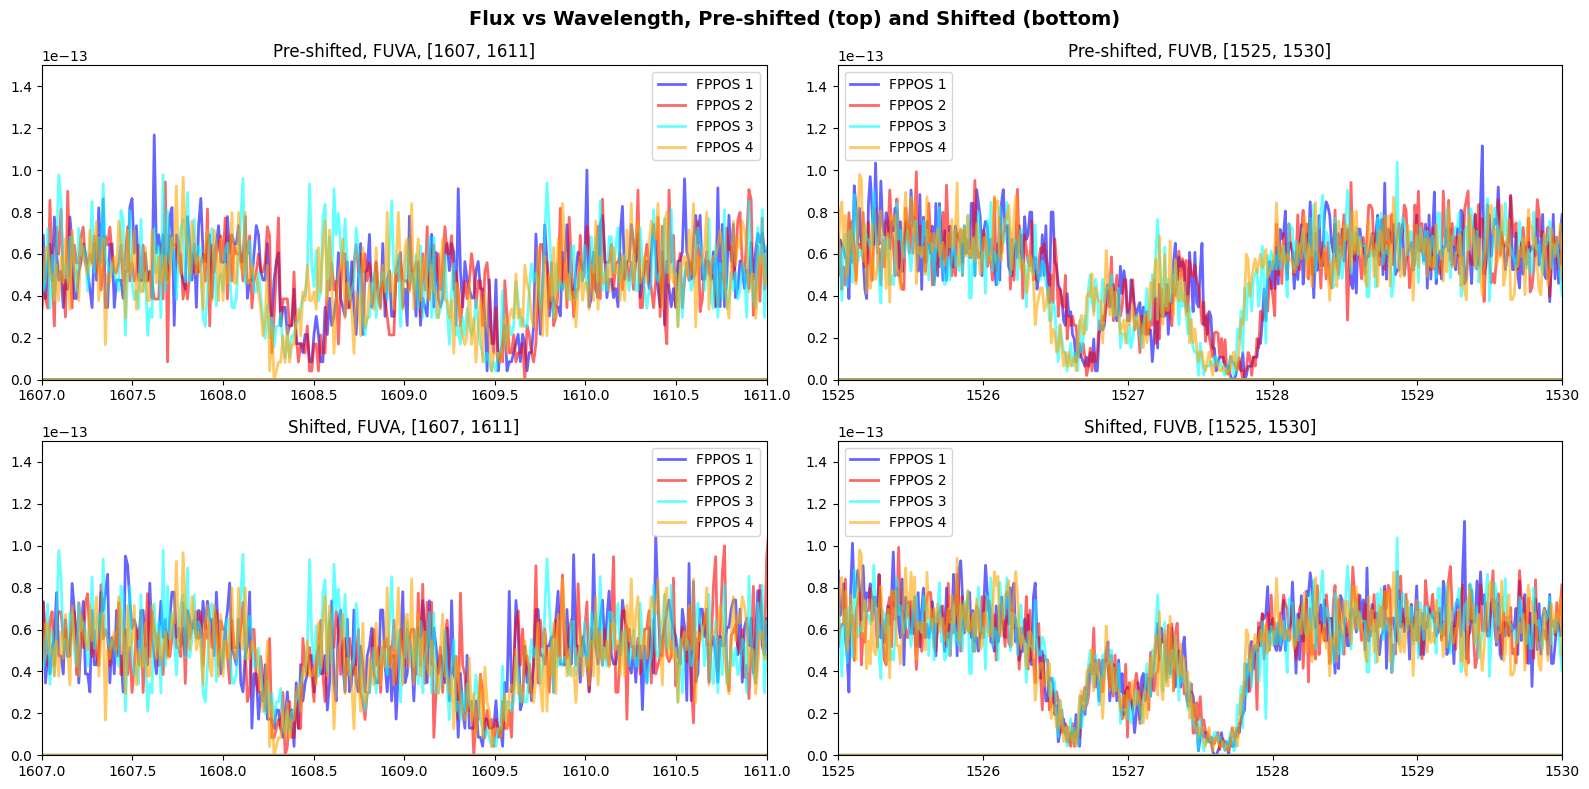

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

# Plotting the unshifted data on the top row
for i, file in enumerate(sorted(cos_unshifted.glob("*x1d.fits*"))):

    with fits.open(file) as hdul:
        wavelength = hdul[1].data["WAVELENGTH"].flatten()
        flux = hdul[1].data["FLUX"].flatten()

    for j in range(0, 2):
        ax[0][j].plot(
            wavelength,
            flux,
            lw=2,
            alpha=0.6,
            label=f'FPPOS {fits.getval(file, "FPPOS")}',
            color=colors[i]
        )

# Now plotting the shifted data on the bottom row
for i, file in enumerate(sorted(cos_shifted.glob("*x1d.fits*"))):
    with fits.open(file) as hdul:

        wavelength = hdul[1].data["WAVELENGTH"].flatten()
        flux = hdul[1].data["FLUX"].flatten()

    for j in range(0, 2):
        ax[1][j].plot(
            wavelength,
            flux,
            lw=2,
            alpha=0.6,
            label=f'FPPOS {fits.getval(file, "FPPOS")}',
            color=colors[i]
        )

# Adding titles
fig.suptitle("Flux vs Wavelength, Pre-shifted (top) and Shifted (bottom)",
             weight="bold",
             fontsize=14)

ax[0][0].set_title(f"Pre-shifted, FUVA, {wavelength_range[0]}")
ax[0][1].set_title(f"Pre-shifted, FUVB, {wavelength_range[1]}")

ax[1][0].set_title(f"Shifted, FUVA, {wavelength_range[0]}")
ax[1][1].set_title(f"Shifted, FUVB, {wavelength_range[1]}")

# Setting xlimits
ax[0][0].set_xlim(wavelength_range[0])
ax[0][1].set_xlim(wavelength_range[1][0], wavelength_range[1][1])

ax[1][0].set_xlim(wavelength_range[0])
ax[1][1].set_xlim(wavelength_range[1][0], wavelength_range[1][1])

# Adding a legend and setting ylim
for subplot in ax.flatten():
    subplot.legend()
    subplot.set_ylim(0, 1.5e-13)

plt.tight_layout()
plt.show()

We can visually see a clear improvement in the spectral features when we applied our shifts to `CalCOS` as the two absorption features have lined up for all `FPPOS`. 

<a id = compare_shifted_cos></a>
### 1.6 Comparing Non-Shifted and Shifted COS Coadds

Now that we've successfully shifted our data, let's re-create our coadd. We will calculate the radial velocity of the new coadd as well and compare it with our values from the earlier section.

In [25]:
!swrapper -i ./cos_ex/cos_shifted -o ./cos_ex/cos_shifted/coadd
clear_output()

Let's see the flux and SNR of our coadd now that we've recalibrated:

/tmp/ipykernel_3136/802807213.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  subplot.legend()


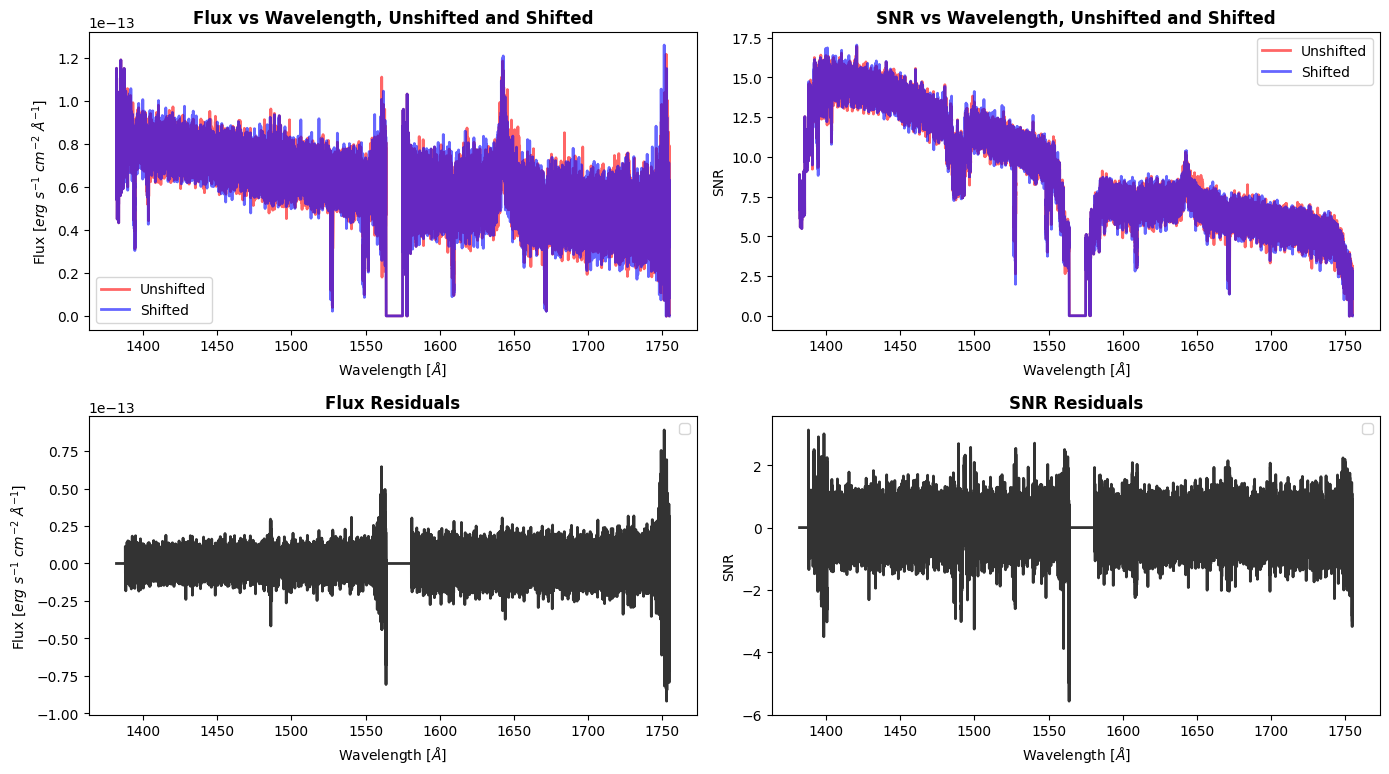

In [26]:
coadd = "hst_15824_cos_lmc079-1_g160m_le27_cspec.fits"

if os.path.exists(cos_unshifted_coadd) or os.path.exists(cos_shifted_coadd):
    
    # The paths to both of our coadds
    preshift = cos_unshifted_coadd / coadd
    shifted = cos_shifted_coadd / coadd

    # Getting the data for our pre- and post-shifted coadd
    with fits.open(preshift) as hdul:
        pre_wl = hdul[1].data["WAVELENGTH"].ravel()
        pre_flux = hdul[1].data["FLUX"].ravel()
        pre_snr = hdul[1].data["SNR"].ravel()

    with fits.open(shifted) as hdul:
        shifted_wl = hdul[1].data["WAVELENGTH"].ravel()
        shifted_flux = hdul[1].data["FLUX"].ravel()
        shifted_snr = hdul[1].data["SNR"].ravel()

    fig, ax = plt.subplots(2, 2, figsize=(14, 8))

    # Interpolating flux and SNR arrays since difference shapes from pre-shifted
    shifted_flux = np.interp(pre_wl, shifted_wl, shifted_flux)
    shifted_snr = np.interp(pre_wl, shifted_wl, shifted_snr)

    # Plotting flux vs wavelength
    ax[0][0].plot(
        pre_wl,
        pre_flux,
        label="Unshifted",
        lw=2,
        alpha=0.6,
        color="red"
    )

    ax[0][0].plot(
        pre_wl,
        shifted_flux,
        label="Shifted",
        lw=2,
        alpha=0.6,
        color="blue"
    )

    # Plotting SNR vs wavelength
    ax[0][1].plot(
        pre_wl,
        pre_snr,
        label="Unshifted",
        lw=2,
        alpha=0.6,
        color="red"
    )

    ax[0][1].plot(
        pre_wl,
        shifted_snr,
        label="Shifted",
        lw=2,
        alpha=0.6,
        color="blue"
    )

    # Plotting flux residuals
    ax[1][0].plot(
        pre_wl,
        shifted_flux-pre_flux,
        lw=2,
        color="black",
        alpha=0.8
    )

    # Plotting snr residuals
    ax[1][1].plot(
        pre_wl,
        shifted_snr-pre_snr,
        lw=2,
        color="black",
        alpha=0.8
    )

    for subplot in ax.ravel():
        subplot.set_xlabel(r'Wavelength [$\AA$]')
        subplot.legend()

    ax[0][0].set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    ax[1][0].set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    ax[0][1].set_ylabel(r'SNR')
    ax[1][1].set_ylabel(r'SNR')

    ax[0][0].set_title("Flux vs Wavelength, Unshifted and Shifted",
                       fontweight="bold")
    ax[1][0].set_title("Flux Residuals",
                       fontweight="bold")

    ax[0][1].set_title("SNR vs Wavelength, Unshifted and Shifted",
                       fontweight="bold")
    ax[1][1].set_title("SNR Residuals",
                       fontweight="bold")

    plt.tight_layout()

    plt.show()
else:
    print("File not found: You need to run previous cells to generate the data.")

While you won't necessarily see a big improvement in the SNR with a shift, we will see that our coadd has a better wavelength solution by calculating the radial velocity below:

The SiII peak is fitted to be 1526.63 Å


/tmp/ipykernel_3136/3560258067.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = optimize.curve_fit(fit_gaussian,


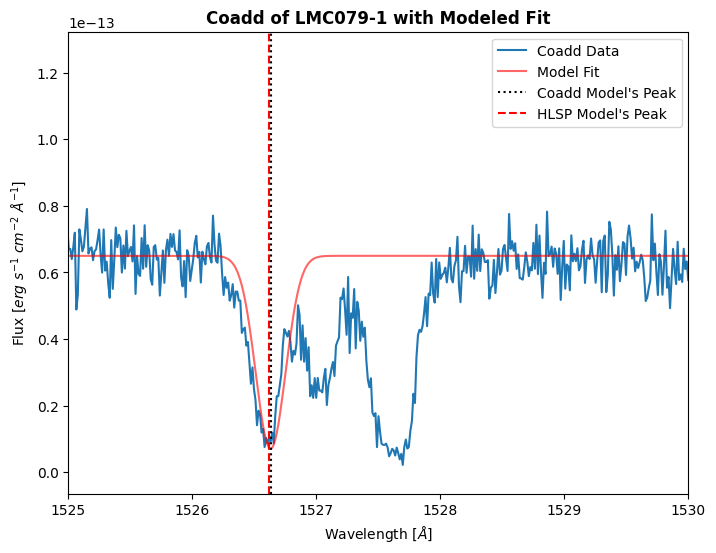

The radial velocity of LMC079-1 using the coadd is roughly -15.67 km/s


In [27]:
new_coadd = cos_shifted_coadd / "hst_15824_cos_lmc079-1_g160m_le27_cspec.fits"

if os.path.exists(cos_shifted_coadd):

    with fits.open(new_coadd) as hdul:
        data_new_coadd = hdul[1].data
        wl_new_coadd = data_new_coadd["WAVELENGTH"].ravel()
        flux_new_coadd = data_new_coadd["FLUX"].ravel()

    # Getting the indicies within the wavelength range
    indicies = np.where((wl_new_coadd >= 1525.) & (wl_new_coadd <= 1525.75))

    trimmed_flux = flux_new_coadd[indicies]
    trimmed_wl = wl_new_coadd[indicies]

    # We need to make an initial guess for the parameter values
    # The array is in form [PEAK OF GAUSSIAN, CENTRAL WAVELENGTH, WIDTH OF LINE]
    p0 = [-0.58e-13, 1526.63, 0.12]

    popt, _ = optimize.curve_fit(fit_gaussian,
                                 trimmed_wl,
                                 trimmed_flux,
                                 p0)

    print(f"The SiII peak is fitted to be {np.round(popt[1], 3)} Å")

    # Plotting the absorption feature of the HLSP with our fit
    plt.figure(figsize=(8, 6))

    # Plotting the actual data
    plt.plot(
        wl_new_coadd,
        flux_new_coadd,
        label="Coadd Data"
    )

    # Plotting our fit
    plt.plot(
        wl_new_coadd,
        fit_gaussian(wl_new_coadd, *popt),
        label="Model Fit",
        color="red",
        alpha=0.6
    )

    # Adding vertical lines to show fitted "peak"
    plt.axvline(popt[1],
                label='Coadd Model\'s Peak',
                color="black",
                linestyle="dotted")

    # Adding vertical line to show observed wl of HLSP
    plt.axvline(popt_hlsp[1],
                label='HLSP Model\'s Peak',
                color="red",
                linestyle="dashed")

    plt.xlim(wavelength_range[1])
    plt.legend()

    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    plt.title("Coadd of LMC079-1 with Modeled Fit",
              fontweight="bold")

    plt.show()

    # Getting the observed wavelength of our HLSP
    observed_wavelength = popt[1]

    v_r = c * ((observed_wavelength - rest_wavelength) / rest_wavelength)
    v_r = np.round(v_r, 2)

    print(f"The radial velocity of LMC079-1 using the coadd is roughly {v_r} km/s")
    
else:
    print("File not found: You need to run previous cells to generate the data.")

The radial velocity of the coadd created with the shifted `X1D` files (`-15.67 km/s`) is a lot closer to the HLSP's radial velocity (`-17.78 km/s`) compared to the radial velocity of the pre-shifted coadd (`-3.5 km/s`). We can now move on to the STIS example.

<a id = mainstis></a>
## 2. Performing Wavelength Adjustments on STIS Data

At the beginning of a science exposure, two Pt-Cr/Ne line lamps are flashed to obtain wavelength calibration exposures and assign a zero-point for the wavelength scale. These wavecals are taken at the beginning of virtually every exposure and are automatically taken at each `2300sec` interval thereafter. Similar to COS, shifts between exposures can occur due to imperfect target acquisitions, repositioning of the grating, and thermal flexure. In these instances, users will need to manually shift their spectra to ensure the correct wavelength and flux calibrations are being performed. Echelle data and low-resolution spectra are suspectable to rapid sensitivity changes with wavelength, which makes accurate wavelength solutions even more important. Information about STIS wavelength accuracies can be found in [Chapter 4.2](https://hst-docs.stsci.edu/stisdhb/chapter-4-stis-error-sources/4-2-summary-of-accuracies) of the STIS Instrument Handbook.

We will be shifting data taken with the `STIS/CCD`, using the `52X2` aperture. There is a small pixel shift between data taken at the nominal position and data taken at the `E1` pseudo-aperture position for this STIS mode (mentioned in [Joyce 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.481.2361J/abstract)). We will download our data using `astroquery`, run the HASP script, cross-correlate the spectra in the dataset to the brightest observation to calculate the wavelength shift, and then apply this shift using `CalSTIS`.

**Note: many of the cross-correlation steps outlined in this notebook are detailed in the [STIS Cross-Correlation Jupyter Notebook](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/STIS/cross-correlation/cross-correlation.ipynb)**

<a id = downloadstis></a>
### 2.1 Downloading and Organizing STIS Data using `Astroquery`

We will be downloading `STIS/CCD G430L` data for the object, `AGK+81D266`, a spectrophotometric target taken in Program 14423. Let's create a few directories for our investigation: 

In [28]:
# To hold all of our STIS example's output and data
stis_ex = Path("./stis_ex")

# To contain the raw files necessary to run CalSTIS
stis_data = Path("./stis_ex/stis_data/")

# To hold the unshifted data products and coadds
stis_unshifted = Path("./stis_ex/stis_unshifted/")
stis_unshifted_coadd = Path("./stis_ex/stis_unshifted/coadd/")

# To contain the shifted data products and coadds
stis_shifted = Path("./stis_ex/stis_shifted/")
stis_shifted_coadd = Path("./stis_ex/stis_shifted/coadd/")

# If the directory doesn't exist then create it
stis_ex.mkdir(exist_ok=True)

stis_data.mkdir(exist_ok=True)

stis_unshifted.mkdir(exist_ok=True)
stis_unshifted_coadd.mkdir(exist_ok=True)

stis_shifted.mkdir(exist_ok=True)
stis_shifted_coadd.mkdir(exist_ok=True)

We can use `astroquery` to query our datasets, get a list of associated products, and download the data to our `./stis_data` directory. This is similar to how we downloaded the COS data in the previous example.

In [29]:
# Querying our datasets
stis_query = Observations.query_criteria(
    proposal_id=14423,
    instrument_name="STIS/CCD",
    filters="G430L",
    target_name="AGK+81D266"
)

# Getting the list of products for our datasets
stis_prodlist = Observations.get_product_list(
    stis_query
)

# Some of the files aren't coadded by default because POSTARG != 0
# We won't download these to save memory space
bad_obsids = [
    "od1am1090",
    "od1am10a0",
    "od1am10c0",
    "od1am10d0",
    "od1am10f0"
]

stis_prodlist = stis_prodlist[~np.isin(stis_prodlist["obs_id"], bad_obsids)]

# Filtering the product list to only get the required files
stis_prodlist = Observations.filter_products(
    stis_prodlist,
    productSubGroupDescription=["SX1", "RAW", "ASN", "FLT"]
)

# Downloading them to ./stis_data
Observations.download_products(
    stis_prodlist,
    download_dir=str(stis_data),
)

# Moving all sub-folders to stis_data and deleting mastDownload folder
consolidate_files(stis_data)

# Moving all sx1 to stis_unshifted
for file in stis_data.glob("*sx1.fits*"):
    # New path for file
    newpath = stis_unshifted / fits.getval(file, 'FILENAME')

    # Moving the actual file
    shutil.move(file, newpath)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Now we will go and download the reference files needed for running `CalSTIS`:

In [30]:
# We will set the CRDS_PATH environment_variable
# Creating path to where the files are saved
crds_path = os.path.join(os.environ["HOME"], "crds_cache")

# Setting the environment variable CRDS_PATH to our CRDS path
os.environ["CRDS_PATH"] = crds_path

# URL for the STScI CRDS page
crds_server_url = "https://hst-crds.stsci.edu"

# Setting env variable to URL
os.environ["CRDS_SERVER_URL"] = crds_server_url

# Set the oref environment variable (STIS)
oref = os.path.join(crds_path, "references/hst/stis/")
os.environ["oref"] = oref

!crds bestrefs --update-bestrefs --sync-references=1 --files ./stis_ex/stis_data/*_raw.fits
clear_output()

<a id = initial_coadd_stis></a>
### 2.2 Running the HASP Script on STIS Data

Now that we have our data downloaded, we can run the coadd script and create abutted products. Check out our [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook for a more detailed look as to how to run the script and change the flag parameters.

In [31]:
!swrapper -i ./stis_ex/stis_unshifted -o ./stis_ex/stis_unshifted/coadd

HASP version 1.2.5
Ullyses version 4.1.0


Creating list of unique modes from these files:
./stis_ex/stis_unshifted/od1al1030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l1')
./stis_ex/stis_unshifted/od1al1040_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'l1')
./stis_ex/stis_unshifted/od1al2030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l2')
./stis_ex/stis_unshifted/od1al2040_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'l2')
./stis_ex/stis_unshifted/od1al4030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l4')
./stis_ex/stis_unshifted/od1al4040_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'l4')
./stis_ex/stis_unshifted/od1am10b0_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'm1')
./stis_ex/stis_unshifted/od1am10e0_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'm1')
Looping over visits
Processing product (14423, 'l1')
Targets in visit (14423, 'l1'): ['AGK+81D266']
Processing target AGK+81D266 in visit (14423, 'l1')
Processing grati

Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al1_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al1_cspec.fits
Only 1 grating to abut, skipping abutment
Processing product (14423, 'l2')
Targets in visit (14423, 'l2'): ['AGK+81D266']
Processing target AGK+81D266 in visit (14423, 'l2')
Processing grating STIS/G430L
Importing files ['./stis_ex/stis_unshifted/od1al2030_sx1.fits', './stis_ex/stis_unshifted/od1al2040_sx1.fits']
Processing file ./stis_ex/stis_unshifted/od1al2030_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1al2040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al2_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al2_cspec.fits
Only 1 grating to

Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al4_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al4_cspec.fits
Only 1 grating to abut, skipping abutment
Processing product (14423, 'm1')
Targets in visit (14423, 'm1'): ['AGK+81D266']
Processing target AGK+81D266 in visit (14423, 'm1')
Processing grating STIS/G430L
Importing files ['./stis_ex/stis_unshifted/od1am10b0_sx1.fits', './stis_ex/stis_unshifted/od1am10e0_sx1.fits']
Processing file ./stis_ex/stis_unshifted/od1am10b0_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1am10e0_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1am1_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1am1_cspec.fits
Only 1 grating to

Processing file ./stis_ex/stis_unshifted/od1al1040_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1al2030_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1al2040_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1al4030_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1al4040_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1am10b0_sx1.fits
Processing file ./stis_ex/stis_unshifted/od1am10e0_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_unshifted/coadd/hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits
Only 1 grating to abut, skipping abutment


We will plot the coadd over our current `SX1` files; the aperture used is also listed in the legend. Observations that were taken at the `E1` position have the value `52X2E1` for the `PROPAPER` header keyword (and are dotted on the plot), whereas observations taken at the nominal position have the value `52X2`. Notice the area around `4860Å` in the second plot shows a visible shift between datasets taken at the nominal and `E1` positions. 

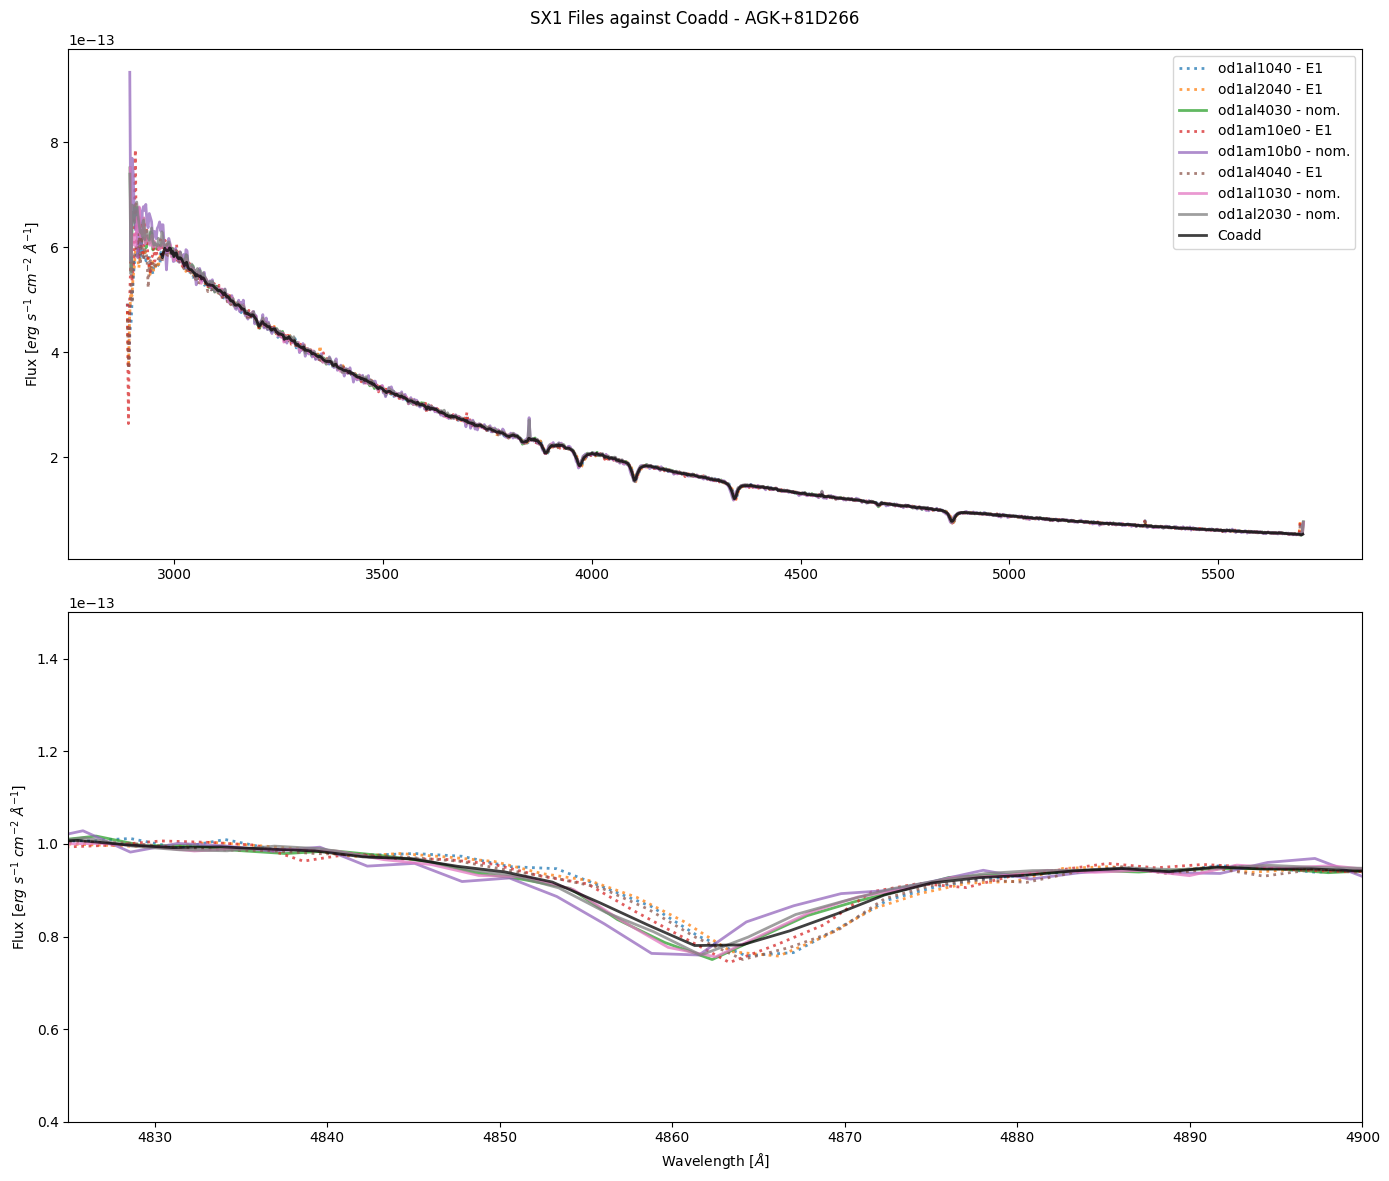

In [32]:
coadd_stis = "hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits"

if os.path.exists(stis_unshifted):

    # A list of the SX1 files for our data
    sx1s = list(stis_unshifted.glob("*sx1*"))

    # Creating a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))

    for curr_plot in ax:
        # Plotting each SX1 file
        for file in sx1s:
            with fits.open(file) as hdul:
                wl = hdul[1].data["WAVELENGTH"].ravel()
                flux = hdul[1].data["FLUX"].ravel()

                aperture = hdul[0].header['PROPAPER']

                # Differentiating between nominal and E1 position via linestyle
                if aperture == "52X2":
                    linestyle = "solid"
                    label = f"{hdul[0].header['ROOTNAME']} - nom."
                else:
                    linestyle = "dotted"
                    label = f"{hdul[0].header['ROOTNAME']} - E1"

                # Plotting the actual data
                curr_plot.plot(wl, flux,
                               label=label,
                               alpha=0.75,
                               lw=2,
                               linestyle=linestyle)

        # Plotting the coadd in black
        with fits.open(stis_unshifted_coadd / coadd_stis) as hdul:
            wl = hdul[1].data["WAVELENGTH"].ravel()
            flux = hdul[1].data["FLUX"].ravel()

            curr_plot.plot(wl, flux,
                           label="Coadd",
                           alpha=0.75,
                           color="black",
                           lw=2)

    # Adding labels, formatting, xlim
    plt.suptitle("SX1 Files against Coadd - AGK+81D266")
    plt.xlabel(r'Wavelength [$\AA$]')
    ax[0].set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    ax[1].set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    ax[1].set_xlim(4825, 4900)
    ax[1].set_ylim(0.4e-13, 1.5e-13)

    ax[0].legend()

    plt.tight_layout()

    plt.show()
else:
    print("File not found: You need to run previous cells to generate the data.")

Since we see a consistent shift in the data between the observations that used the `E1` aperture and the nominal, we need to determine the actual shift in pixels and re-run `CalSTIS` on our data. We will not be calculating the radial velocity and comparing it to the literature value to reduce notebook length, and because the shift is known to be relative to the nominal position.

<a id = cross_correlate_stis></a>
### 2.3 Performing Cross-Correlation on STIS data and Calculating Lag

There are multiple ways to determine the best observation to set as the reference, and that is up to the user to do so. Since we are shifting all the `E1` observations to the nominal positions, we will use the brightest nominal observation as our reference. We are using the brightest because we are making the assumption that it is the observation most centered in the aperture, but you will need to use other methods when determining the file to reference to. Let's determine the brightest nominal file below:

In [33]:
# A variable for the brightest filename, arbitrarily
ref_file = sx1s[0]

for file in sx1s:
    # Getting flux data for current interation's file + current brightest file
    with fits.open(file) as hdul:
        curr_flux = hdul[1].data["FLUX"].ravel()
        aperture = hdul[0].header["PROPAPER"]

    with fits.open(ref_file) as ref_hdul:
        ref_flux = ref_hdul[1].data["FLUX"].ravel()

    # If current file's mean flux > ref file, replace ref file
    if ((np.mean(curr_flux) > np.mean(ref_flux)) & (aperture == "52X2")):
        ref_file = file

    else:
        continue

# Printing out our file
print(f"The brightest file is {ref_file.name}.")

The brightest file is od1al2030_sx1.fits.


We've now determined that `od1al2030_sx1.fits` is the brightest spectra of our data. We will go through each `SX1` file taken at the `E1` position in our data and cross-correlate it to our `od1al2030_sx1.fits` file. We will calculate the shifts for a single file first (to better illustrate each step), then define a function to perform these same steps for the rest of the files.

We will be cross-correlating similarly to how we did our COS example in the previous section, but this section will mainly follow the steps in the official [STIS Cross-Correlation Notebook](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/STIS/cross-correlation/cross-correlation.ipynb).

We will need to calculate the mean plate scale, i.e. the dispersion per pixel, for our reference dataset. This will be used to determine the shift in pixels later on in the tutorial.

In [34]:
# Getting a list of files taken at E1 position
e1_pos = [file for file in sx1s if fits.getval(file, "PROPAPER") != "52X2"]

# Example file
stis_file = e1_pos[0]

# Getting the data for the reference file
with fits.open(ref_file) as hdul:
    ref_wl = hdul[1].data["WAVELENGTH"].ravel()
    ref_flux = hdul[1].data["FLUX"].ravel()

with fits.open(stis_file) as hdul:
    ex_wl = hdul[1].data["WAVELENGTH"].ravel()
    ex_flux = hdul[1].data["FLUX"].ravel()

# Interpolating the example spectra
ex_flux = np.interp(ref_wl, ex_wl, ex_flux)

# Getting the dispersion per pixel
mean_plate_scale = np.mean(ref_wl[1:] - ref_wl[:-1])
print(f"The dispersion per pixel is {np.round(mean_plate_scale, 2)} Å/pixel")

The dispersion per pixel is 2.75 Å/pixel


Now we will use our cross-correlation function defined in the COS section to determine the lag and cross-correlation coefficient. We can determine the shift by getting the lag value with the highest corresponding cross-correlation coefficient. Our lags are discrete pixel integer values, so we will need to fit a quadratic curve using `fitting` and `Polynomial1D` from the `astropy.modeling` module. The lag at the maxima of our fit is the pixel shift that we will use when re-calibrating with `CalSTIS`.

**Note: you will need to experiment with different fits when determining your lag; there is no single function that will work in all scenarios**

The shift, in pixels, is 1.17 pixels
The shift, in angstroms, is 3.21Å


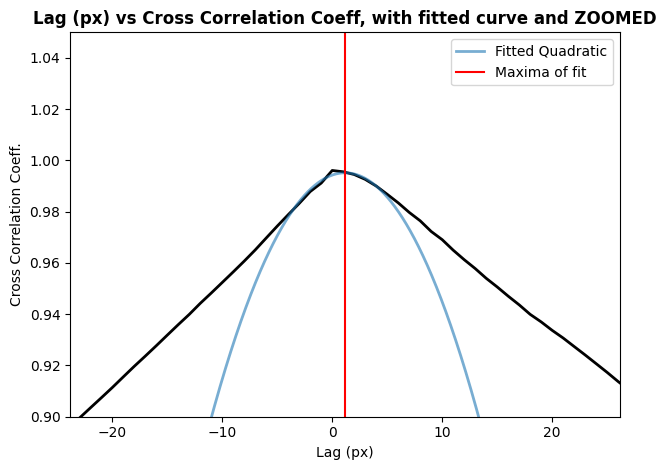

In [35]:
# Calculating the lag and cc coeff using the earlier defined function
lag, cc = cross_correlate(ref_flux, ex_flux)

# Fitting a quadratic to the peak to find pixel shift
fitter = fitting.LinearLSQFitter()

# Getting the 8 points near the peak
width = 8

low, hi = np.argmax(cc) - width//2, np.argmax(cc) + width//2 + 1
fit = fitter(Polynomial1D(degree=2), x=lag[low:hi], y=cc[low:hi])

x_c = np.arange(np.min(lag), np.max(lag), 0.01)

# Determining the shift, in pixels
shift1 = -fit.parameters[1] / (2. * fit.parameters[2])

print(f"The shift, in pixels, is {np.round(shift1, 2)} pixels")
print(f"The shift, in angstroms, is {np.round(shift1*mean_plate_scale, 2)}Å")

plt.plot(
    lag,
    cc,
    lw=2,
    color="black"
)

plt.plot(
    x_c,
    fit(x_c),
    lw=2,
    label="Fitted Quadratic",
    alpha=0.6
)

plt.axvline(
    shift1,
    color="red",
    label="Maxima of fit"
)

# Adding title
plt.title("Lag (px) vs Cross Correlation Coeff, with fitted curve and ZOOMED",
          weight="bold")

plt.xlabel("Lag (px)")
plt.ylabel("Cross Correlation Coeff.")

plt.ylim(0.9, 1.05)
plt.xlim(shift1 - 25, shift1 + 25)

plt.legend()

plt.tight_layout()

plt.show()

<a id = run_calstis></a>
### 2.4 Applying Shifts to Raw STIS data and Re-creating Coadd
Now that we've calculated the shift, we need to alter the header keywords of our data and then re-calibrate the spectrum using `CalSTIS`. We will extract the `SHIFTA1` and `SHIFTA2` keywords from the corresponding `FLT` file, add our calculated shift value to the value of this keyword, then set the `WAVECORR` calibration switch in the `RAW` file to `OMIT` and re-run `CalSTIS`.

In [36]:
# Path to the FLT for our example file
flt_file = stis_data / f"{fits.getval(stis_file, 'ROOTNAME')}_flt.fits"

# Extracting the shift from the FLT file
SHIFTA1 = fits.getval(flt_file, "SHIFTA1", ext=1)
SHIFTA2 = fits.getval(flt_file, "SHIFTA2", ext=1)

# Update SHIFTA1 (spectral direction) to take into account the calculated shift
SHIFTA1 += shift1

# Path to the raw file
raw_file = stis_data / f"{fits.getval(stis_file, 'ROOTNAME')}_raw.fits"

# Updating the header to reflect updated shift + FLT SHIFTA2 value
fits.setval(raw_file, keyword="SHIFTA1", value=SHIFTA1, ext=1)
fits.setval(raw_file, keyword="SHIFTA2", value=SHIFTA2, ext=1)

# Set WAVECORR to OMIT since we're applying the shift
fits.setval(raw_file, "WAVECORR", value="OMIT", ext=0)

Now we can run `CalSTIS`:

In [37]:
try:
    stistools.calstis.calstis(str(raw_file),
                              outroot=str(stis_shifted))
    
except RuntimeError as e:
    print('An error occured', e)


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC

Input    stis_ex/stis_data/od1al1040_raw.fits
Outroot  stis_ex/stis_shifted

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC
Input    stis_ex/stis_data/od1al1040_raw.fits
Output   stis_ex/stis_shifted_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 20:28:46 UTC
Epcfile  od1al1b1j_epc.fits
Warning  EPCTAB `od1al1b1j_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM


         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1450.05.
BLEVCORR COMPLETE
         Uncertainty array initialized, readnoise=6.24, gain=1

BIASCORR PERFORM
BIASFILE oref$02a1919to_bia.fits
BIASFILE PEDIGREE=INFLIGHT 08/11/2015 16/11/2015
BIASFILE DESCRIP =Weekly gain=1 bias for STIS CCD data taken after Nov 08 2015-------
BIASCORR COMPLETE

DARKCORR OMIT

FLATCORR OMIT

SHADCORR OMIT

PHOTCORR OMIT
Imset 1  End 20:28:46 UTC

Imset 2  Begin 20:28:46 UTC
Epcfile  od1al1b2j_epc.fits
Warning  EPCTAB `od1al1b2j_epc.fits' not found.

DQICORR  PERFORM
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1451.58.
BLEVCORR COMPLETE
         Uncertainty array initialized, readnoise=6.24, gain=1

BIASCORR PERFORM
BIASCORR COMPLETE

DARKCORR OMIT

FLATCORR OMIT

SHADCORR OMIT
Imset 2  End 20:28:46 UTC

End      02-Dec-2025 20:28:46 UTC

*** CALSTIS

We will now define a function to calculate and perform shifts on the rest of the `E1` position datasets. We have three remaining files to shift, so we will define a function to calculate the fit, plot, and run `CalSTIS`. 

**Note that you will need to experiment with different fits/functions for your dataset.**

In [38]:
def shift_stis(ref_file, stis_file, width, plot, run_calstis=False):
    '''
    Determing the shift, in pixels, between the file and the reference.
    Update the RAW file with the new shift and run CalSTIS.
    ----------
    Input:
    pathlib.Path or str ref_file : Path to the reference file
    pathlib.Path or str stis_file : Path to the file that needs to be shifted
    int width : Number points to fit at the peak of the function, must be > 2
    bool plot : Do you want to plot the cc function and the fit?
    bool run_calstis : True if you want to run CalSTIS on the shifted dataset
    '''
    # Getting the data for the reference file
    with fits.open(ref_file) as hdul:
        ref_wl = hdul[1].data["WAVELENGTH"].ravel()
        ref_flux = hdul[1].data["FLUX"].ravel()

    with fits.open(stis_file) as hdul:
        ex_wl = hdul[1].data["WAVELENGTH"].ravel()
        ex_flux = hdul[1].data["FLUX"].ravel()

    # Interpolating the example spectra
    ex_flux = np.interp(ref_wl, ex_wl, ex_flux)

    # Getting the dispersion per pixel
    mean_plate_scale = np.mean(ref_wl[1:] - ref_wl[:-1])

    print(f"Dispersion per pixel is {np.round(mean_plate_scale, 2)} Å/pixel")

    # Calculating the lag and cc coeff using the earlier defined function
    lag, cc = cross_correlate(ref_flux, ex_flux)

    # Fitting a quadratic to the peak to find pixel shift
    fitter = fitting.LinearLSQFitter()

    low, hi = np.argmax(cc) - width//2, np.argmax(cc) + width//2 + 1
    fit = fitter(Polynomial1D(degree=2), x=lag[low:hi], y=cc[low:hi])

    x_c = np.arange(np.min(lag), np.max(lag), 0.01)

    # Determining the shift, in pixels
    shift1 = -fit.parameters[1] / (2. * fit.parameters[2])

    print(f"The shift, in pixels, is {np.round(shift1, 2)} pixels")
    print(f"The shift, in Å, is {np.round(shift1*mean_plate_scale, 2)}Å")

    if plot:
        plt.plot(
            lag,
            cc,
            lw=2,
            color="black",
            alpha=0.8
        )

        plt.plot(
            x_c,
            fit(x_c),
            lw=2,
            label="Fitted Quadratic",
            alpha=0.6
        )

        plt.axvline(
            shift1,
            color="red",
            label="Maxima of fit"
        )

        # Adding title
        plt.title("Lag (px) vs Cross Correlation Coeff, with fitted curve",
                  weight="bold")

        plt.xlabel("Lag (px)")
        plt.ylabel("Cross Correlation Coeff.")

        plt.ylim(0.9, 1.05)
        plt.xlim(shift1 - 25, shift1 + 25)

        plt.legend()

        plt.tight_layout()

        plt.show()

    if run_calstis:
        # Path to the FLT for our example file
        flt_file = f"{stis_data}/{fits.getval(stis_file, 'ROOTNAME')}_flt.fits"

        # Extracting the shift from the FLT file
        SHIFTA1 = fits.getval(flt_file, "SHIFTA1", ext=1)
        SHIFTA2 = fits.getval(flt_file, "SHIFTA2", ext=1)

        # Update SHIFTA1 (spectral direction) to include the calculated shift
        SHIFTA1 += shift1

        # Path to the raw file
        raw_file = f"{stis_data}/{fits.getval(stis_file, 'ROOTNAME')}_raw.fits"

        # Updating the header to reflect updated shift + FLT SHIFTA2 value
        fits.setval(raw_file, keyword="SHIFTA1", value=SHIFTA1, ext=1)
        fits.setval(raw_file, keyword="SHIFTA2", value=SHIFTA2, ext=1)

        # Set WAVECORR to OMIT since we're applying the shift
        fits.setval(raw_file, "WAVECORR", value="OMIT", ext=0)

        stistools.calstis.calstis(raw_file,
                                  verbose=False,
                                  outroot=f"{str(stis_shifted)}/")

Let's shift `od1al4040_sx1.fits`:

In [39]:
width = 7
try:
    shift_stis(ref_file, e1_pos[1], width, plot=False, run_calstis=True)
except RuntimeError as e:
    print('An error occured', e)

Dispersion per pixel is 2.75 Å/pixel
The shift, in pixels, is 0.73 pixels
The shift, in Å, is 2.01Å



*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC

Input    stis_ex/stis_data/od1al2040_raw.fits
Outroot  stis_ex/stis_shifted/od1al2040_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC
Input    stis_ex/stis_data/od1al2040_raw.fits
Output   stis_ex/stis_shifted/od1al2040_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 20:28:46 UTC
Epcfile  od1al2yrj_epc.fits
Warning  EPCTAB `od1al2yrj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bia

Now `od1am10e0_sx1.fits`:

In [40]:
width = 9
try:
    shift_stis(ref_file, e1_pos[2], width, plot=False, run_calstis=True)
except RuntimeError as e:
    print('An error occured', e)

Dispersion per pixel is 2.75 Å/pixel
The shift, in pixels, is 0.57 pixels
The shift, in Å, is 1.56Å



*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC

Input    stis_ex/stis_data/od1am10e0_raw.fits
Outroot  stis_ex/stis_shifted/od1am10e0_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC
Input    stis_ex/stis_data/od1am10e0_raw.fits
Output   stis_ex/stis_shifted/od1am10e0_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 20:28:46 UTC
Epcfile  od1am1hnj_epc.fits
Warning  EPCTAB `od1am1hnj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bia

And finally, `od1al1040_sx1.fits`:

In [41]:
width = 7
try:
    shift_stis(ref_file, e1_pos[3], width, plot=False, run_calstis=True)
except RuntimeError as e:
    print('An error occured', e)

Dispersion per pixel is 2.75 Å/pixel
The shift, in pixels, is 0.76 pixels
The shift, in Å, is 2.1Å



*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC

Input    stis_ex/stis_data/od1al4040_raw.fits
Outroot  stis_ex/stis_shifted/od1al4040_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:46 UTC
Input    stis_ex/stis_data/od1al4040_raw.fits
Output   stis_ex/stis_shifted/od1al4040_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 20:28:46 UTC
Epcfile  od1al4axj_epc.fits
Warning  EPCTAB `od1al4axj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bia

A file taken in the nominal position, `od1am10b0` is also shifted, so we will fix that too:

In [42]:
width = 15
filepath = stis_unshifted / "od1am10b0_sx1.fits"

try:
    shift_stis(ref_file, filepath, width, plot=False, run_calstis=True)
except RuntimeError as e:
    print('An error occured', e)

Dispersion per pixel is 2.75 Å/pixel
The shift, in pixels, is -0.49 pixels
The shift, in Å, is -1.35Å



*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:47 UTC

Input    stis_ex/stis_data/od1am10b0_raw.fits
Outroot  stis_ex/stis_shifted/od1am10b0_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    02-Dec-2025 20:28:47 UTC
Input    stis_ex/stis_data/od1am10b0_raw.fits
Output   stis_ex/stis_shifted/od1am10b0_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 20:28:47 UTC
Epcfile  od1am1hgj_epc.fits
Warning  EPCTAB `od1am1hgj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bia

<a id = compare_shifted_stis></a>
## 2.5 Comparing Non-Adjusted and Adjusted STIS Coadds

Now that we've applied the shifts to our data, we will re-run the coadd code. To get a proper comparison, we will need to copy over the files taken at the nominal position to the `stis_shifted` directory since the coadd code needs all `X1D`/`SX1` files in the same directory.

In [43]:
for file in sx1s:
    if file.name == "od1am10b0_sx1.fits":
        continue

    if fits.getval(file, "PROPAPER") == "52X2":
        new_path = stis_shifted / os.path.basename(file)
        shutil.copy(file, new_path)

And now we run the coadd script:

In [44]:
!swrapper -i ./stis_ex/stis_shifted -o ./stis_ex/stis_shifted/coadd

HASP version 1.2.5
Ullyses version 4.1.0


Creating list of unique modes from these files:
./stis_ex/stis_shifted/od1al1030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l1')
./stis_ex/stis_shifted/od1al2030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l2')
./stis_ex/stis_shifted/od1al2040_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'l2')
./stis_ex/stis_shifted/od1al4030_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'l4')
./stis_ex/stis_shifted/od1al4040_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'l4')
./stis_ex/stis_shifted/od1am10b0_sx1.fits AGK+81D266 STIS CCD G430L 52X2 0 14423 (14423, 'm1')
./stis_ex/stis_shifted/od1am10e0_sx1.fits AGK+81D266 STIS CCD G430L 52X2E1 0 14423 (14423, 'm1')
Looping over visits
Processing product (14423, 'l1')
Targets in visit (14423, 'l1'): ['AGK+81D266']
Processing target AGK+81D266 in visit (14423, 'l1')
Processing grating STIS/G430L
Importing files ['./stis_ex/stis_shifted/od1al1030_sx1.fits']
Processing file ./stis_ex/stis_shifte

Processing file ./stis_ex/stis_shifted/od1al4040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al4_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266_g430l_od1al4_cspec.fits
Only 1 grating to abut, skipping abutment
Processing product (14423, 'm1')
Targets in visit (14423, 'm1'): ['AGK+81D266']
Processing target AGK+81D266 in visit (14423, 'm1')
Processing grating STIS/G430L
Importing files ['./stis_ex/stis_shifted/od1am10b0_sx1.fits', './stis_ex/stis_shifted/od1am10e0_sx1.fits']
Processing file ./stis_ex/stis_shifted/od1am10b0_sx1.fits
Processing file ./stis_ex/stis_shifted/od1am10e0_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266_g430l_od1am1_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266

Processing file ./stis_ex/stis_shifted/od1al2030_sx1.fits
Processing file ./stis_ex/stis_shifted/od1al2040_sx1.fits
Processing file ./stis_ex/stis_shifted/od1al4030_sx1.fits
Processing file ./stis_ex/stis_shifted/od1al4040_sx1.fits
Processing file ./stis_ex/stis_shifted/od1am10b0_sx1.fits
Processing file ./stis_ex/stis_shifted/od1am10e0_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_ex/stis_shifted/coadd/hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits
Only 1 grating to abut, skipping abutment


And we can now compare our pre-shifted and shifted data and their coadds.

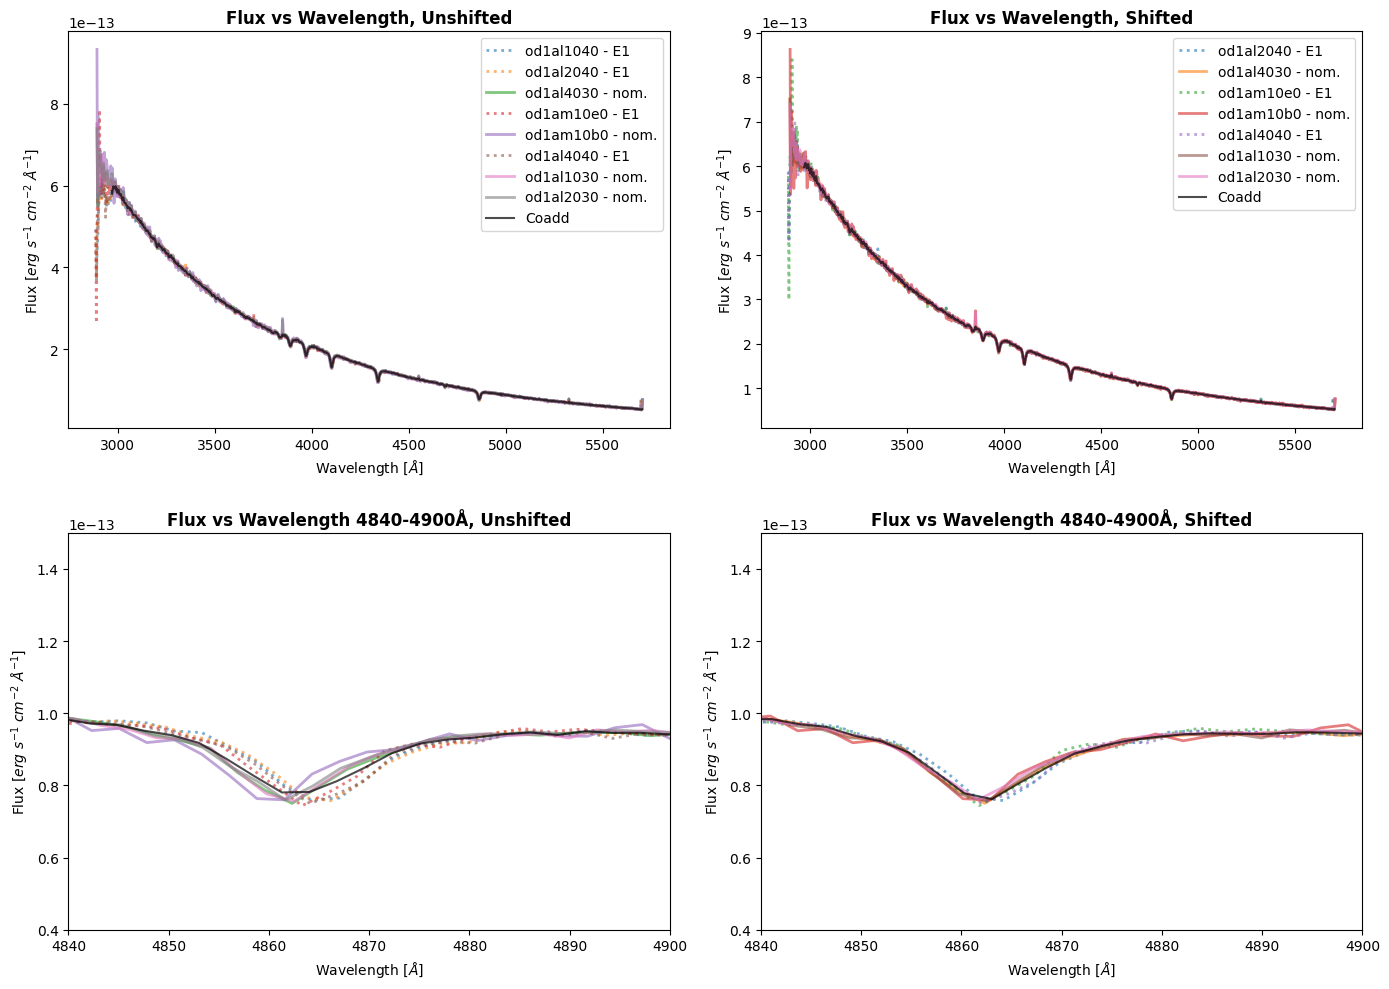

In [45]:
coadd = "hst_14423_stis_agkp81d266_g430l_od1a_cspec.fits"

if os.path.exists(stis_unshifted):

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    types = [stis_unshifted, stis_shifted]

    for i, is_shifted in enumerate(types):
        for file in is_shifted.glob("*sx1*"):
            with fits.open(file) as hdul:
                wl = hdul[1].data["WAVELENGTH"].ravel()
                flux = hdul[1].data["FLUX"].ravel()

                aperture = hdul[0].header['PROPAPER']

                # Differentiating between nominal and E1 position via linestyle
                if aperture == "52X2":
                    linestyle = "solid"
                    label = f"{hdul[0].header['ROOTNAME']} - nom."
                else:
                    linestyle = "dotted"
                    label = f"{hdul[0].header['ROOTNAME']} - E1"

            ax[0][i].plot(
                wl,
                flux,
                lw=2,
                alpha=0.6,
                label=label,
                linestyle=linestyle
            )

            ax[1][i].plot(
                wl,
                flux,
                lw=2,
                alpha=0.6,
                label=label,
                linestyle=linestyle
            )

        # Plotting the coadd
        with fits.open(f"{is_shifted}/coadd/{coadd}") as hdul:
            wl = hdul[1].data["WAVELENGTH"].ravel()
            flux = hdul[1].data["FLUX"].ravel()

        ax[0][i].plot(
            wl,
            flux,
            label="Coadd",
            color="black",
            alpha=0.7
        )

        ax[1][i].plot(
            wl,
            flux,
            label="Coadd",
            color="black",
            alpha=0.7
        )

        # All plots will have same labels
        for subplot in ax[i].ravel():
            subplot.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
            subplot.set_xlabel(r'Wavelength [$\AA$]')

        shifted = ['Unshifted', 'Shifted'][i]

        ax[0][i].set_title(f"Flux vs Wavelength, {shifted}",
                           fontweight="bold")
        ax[1][i].set_title(f"Flux vs Wavelength 4840-4900Å, {shifted}",
                           fontweight="bold")

        ax[1][i].set_xlim(4840, 4900)
        ax[1][i].set_ylim(0.4e-13, 1.5e-13)

        ax[0][i].legend()

    plt.tight_layout()
    plt.show()
else:
    print("File not found: You need to run previous cells to generate the data.")

We can see the offsets between the datasets taken at the nominal position and the `E1` position are reduced after we've applied our shifts and run `CalSTIS`. While we did a very rough estimate of the shift, users will want to verify that they have the correct wavelength solution through their own methods (e.g. checking expected wavelengths to observed wavelengths, comparing radial velocities, etc.).

# Congrats on completing the notebook!

### There are more tutorial notebooks for custom coaddition cases in [this](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP) repo, check them out!

## About this Notebook
**Author:** Sierra Gomez (sigomez@stsci.edu)

**Updated on:** August 29, 2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `astroquery`, or `matplotlib`, `numpy` for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)
<hr>
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 